# Comparison with EventDisplay

**Purpose of this notebook:**

Compare IRF and Sensitivity as computed by pyirf and EventDisplay on the same DL2 results

**Notes:**

The following results correspond to:

- Paranal site
- Zd 20 deg, Az 180 deg
- 50 h observation time

**Resources:**

_EventDisplay_ DL2 data, https://forge.in2p3.fr/projects/cta_analysis-and-simulations/wiki/Eventdisplay_Prod3b_DL2_Lists


Download and unpack the data using 

```bash
$ curl -fL -o data.zip https://nextcloud.e5.physik.tu-dortmund.de/index.php/s/Cstsf8MWZjnz92L/download
$ unzip data.zip
$ mv eventdisplay_dl2 data
```

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports

In [1]:
import os

import numpy as np
import uproot
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable
from matplotlib.ticker import ScalarFormatter

from pyirf.binning import bin_center

%matplotlib inline

/usr/local/lib/python3.8/site-packages/setuptools_scm/git.py:88: UserWarning: "/github/workspace" is shallow and may cause errors
  warnings.warn(f'"{wd.path}" is shallow and may cause errors')
/usr/local/lib/python3.8/site-packages/traitlets/traitlets.py:3030: FutureWarning: --rc={'figure.dpi': 300} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


In [2]:
plt.rcParams['figure.figsize'] = (9, 6)

## Input data

### _EventDisplay_

The input data provided by _EventDisplay_ is stored in _ROOT_ format, so _uproot_ is used to transform it into _numpy_ objects. 

In [3]:
# Path of EventDisplay IRF data in the user's local setup
# Please, empty the indir_EventDisplay variable before pushing to the repo
indir = "../../data/"
irf_file_event_display = "DESY.d20180113.V3.ID0NIM2LST4MST4SST4SCMST4.prod3b-paranal20degs05b-NN.S.3HB9-FD.180000s.root"

irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))

## _pyirf_

The following is the current IRF + sensititivy output FITS format provided by this software.

Run `python examples/calculate_eventdisplay_irfs.py` after downloading the data

In [4]:
pyirf_file = '../../pyirf_eventdisplay.fits.gz'

## Optimized cuts
[back to top](#Table-of-contents)

### Direction cut
[back to top](#Table-of-contents)

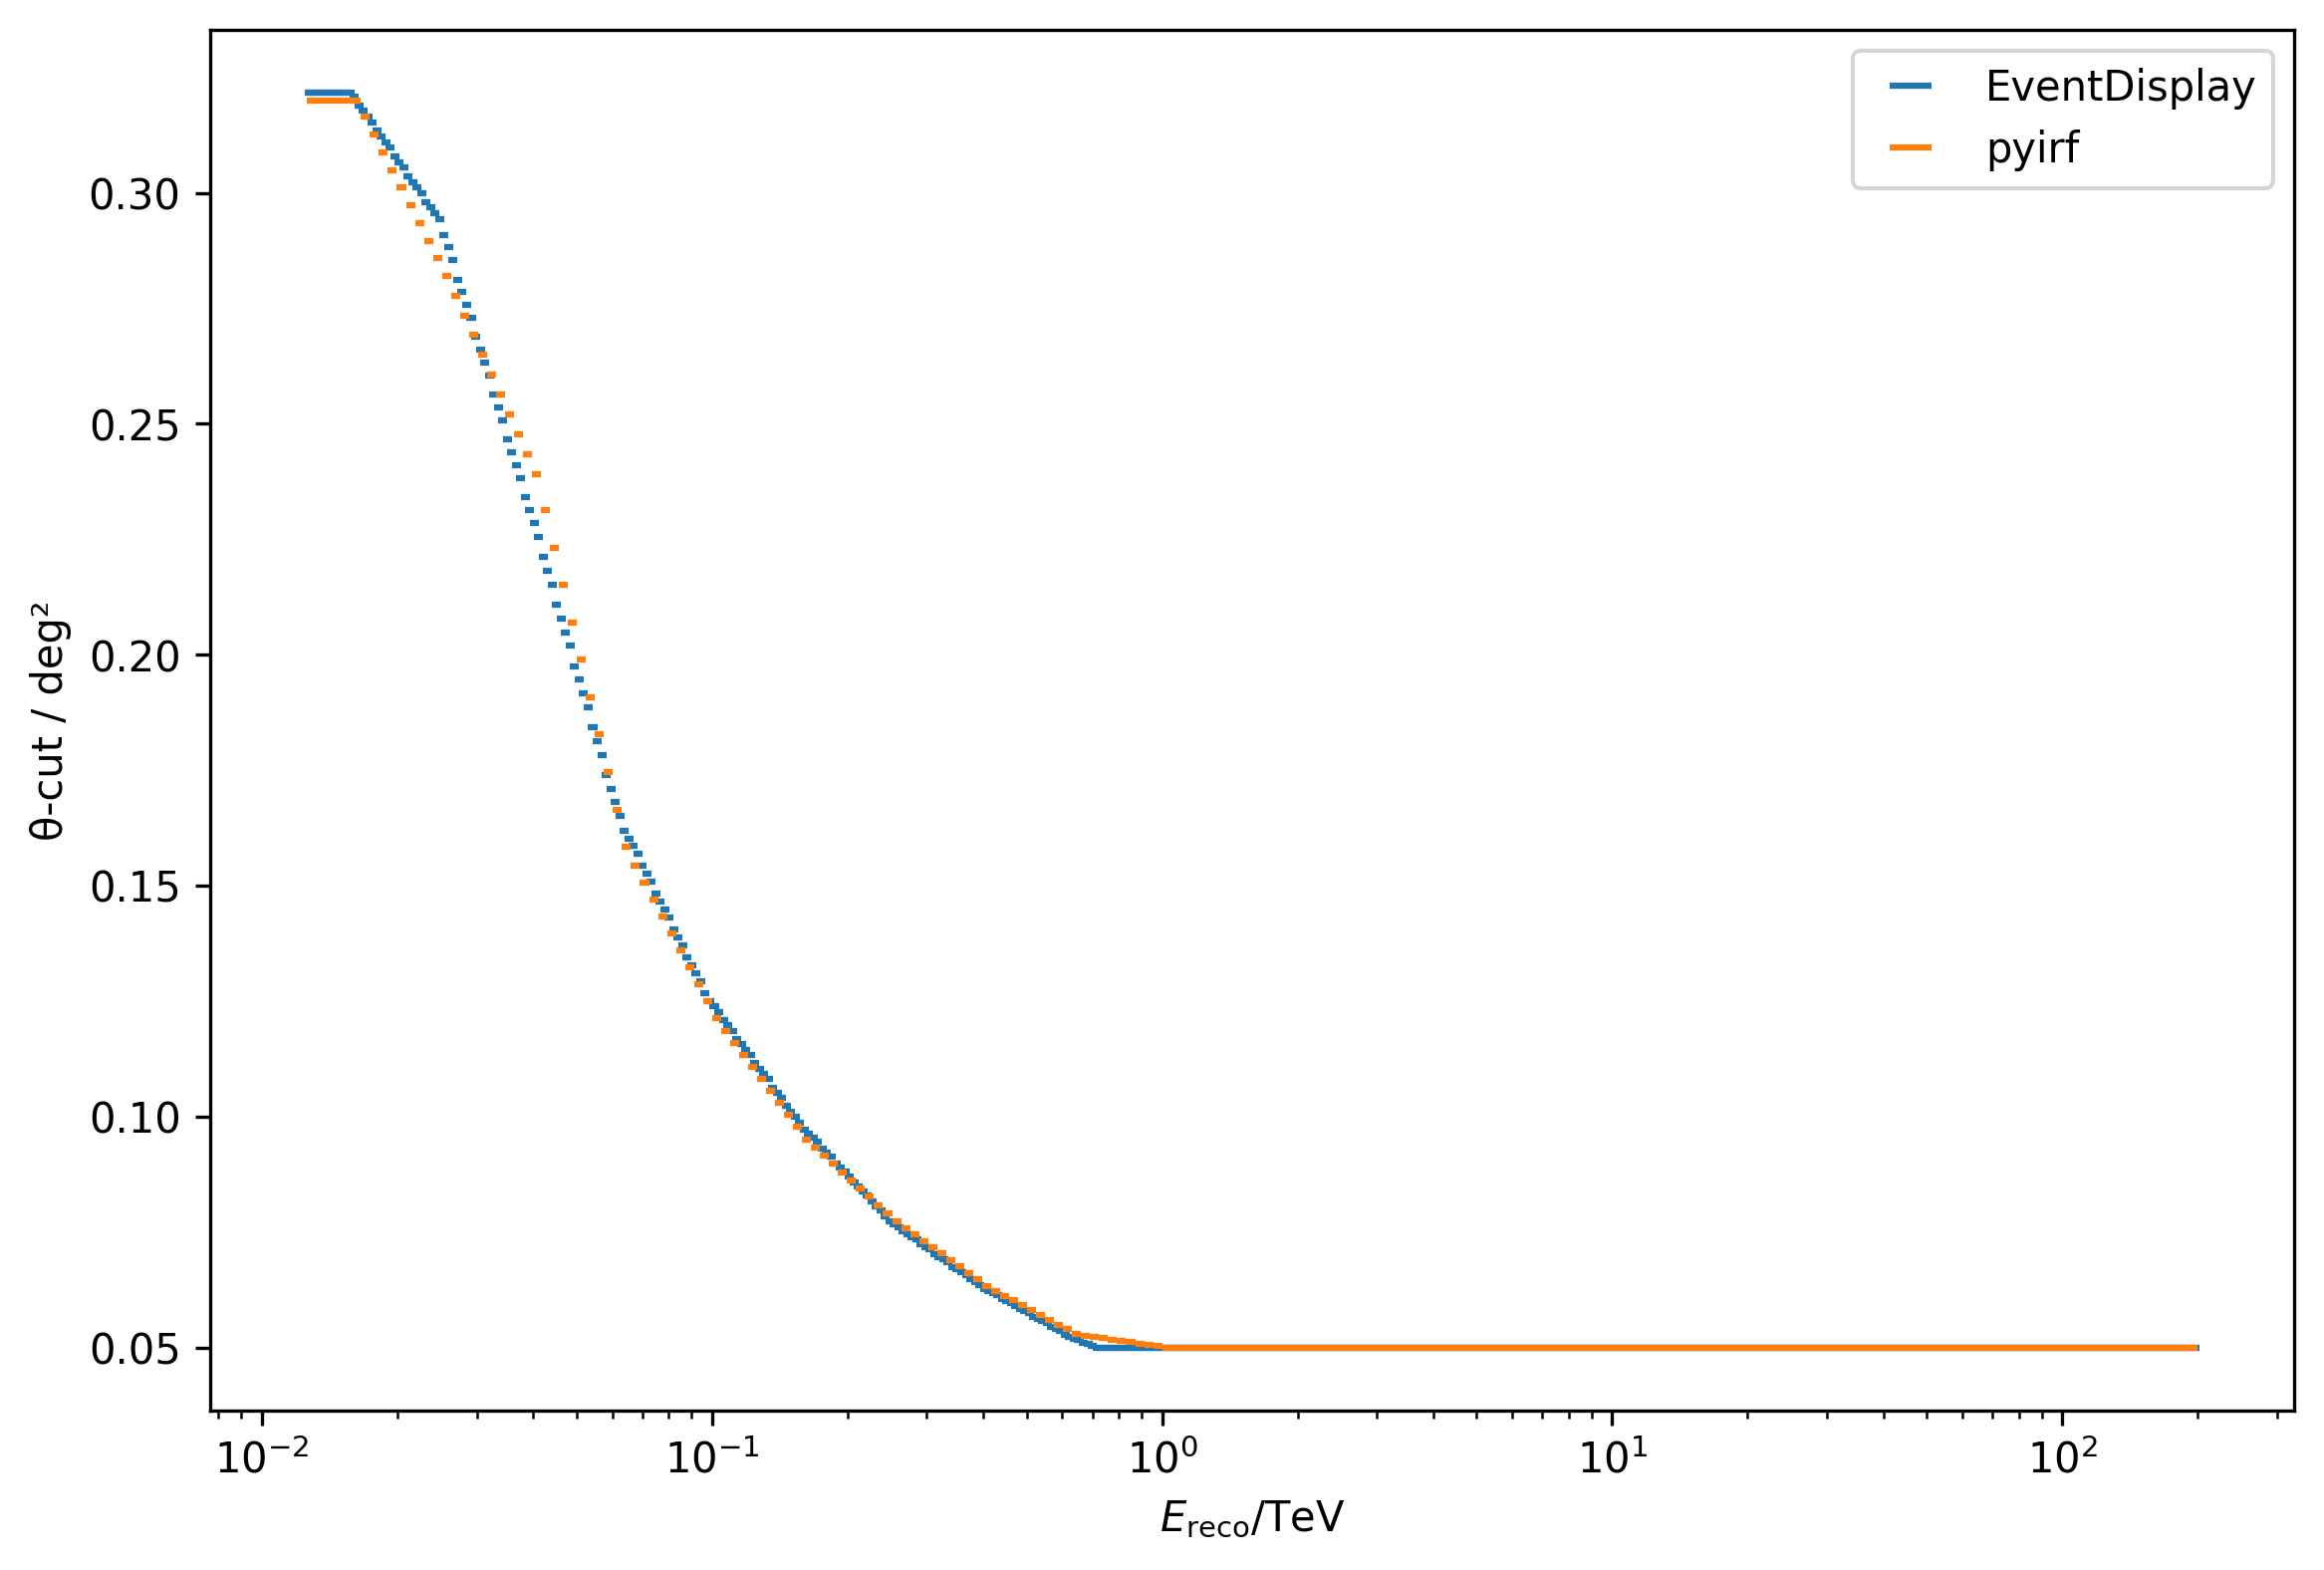

In [5]:
from astropy.table import QTable


rad_max = QTable.read(pyirf_file, hdu='RAD_MAX')[0]


theta_cut_ed, edges = irf_eventdisplay['ThetaCut;1'].to_numpy()



plt.errorbar(
    bin_center(10**edges),
    theta_cut_ed,
    xerr=np.diff(10**edges),
    ls='',
    label='EventDisplay',
)

plt.errorbar(
    0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
    rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg),
    xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
    ls='',
    label='pyirf',
)

plt.legend()
plt.ylabel('θ-cut / deg²')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')

None # to remove clutter by mpl objects

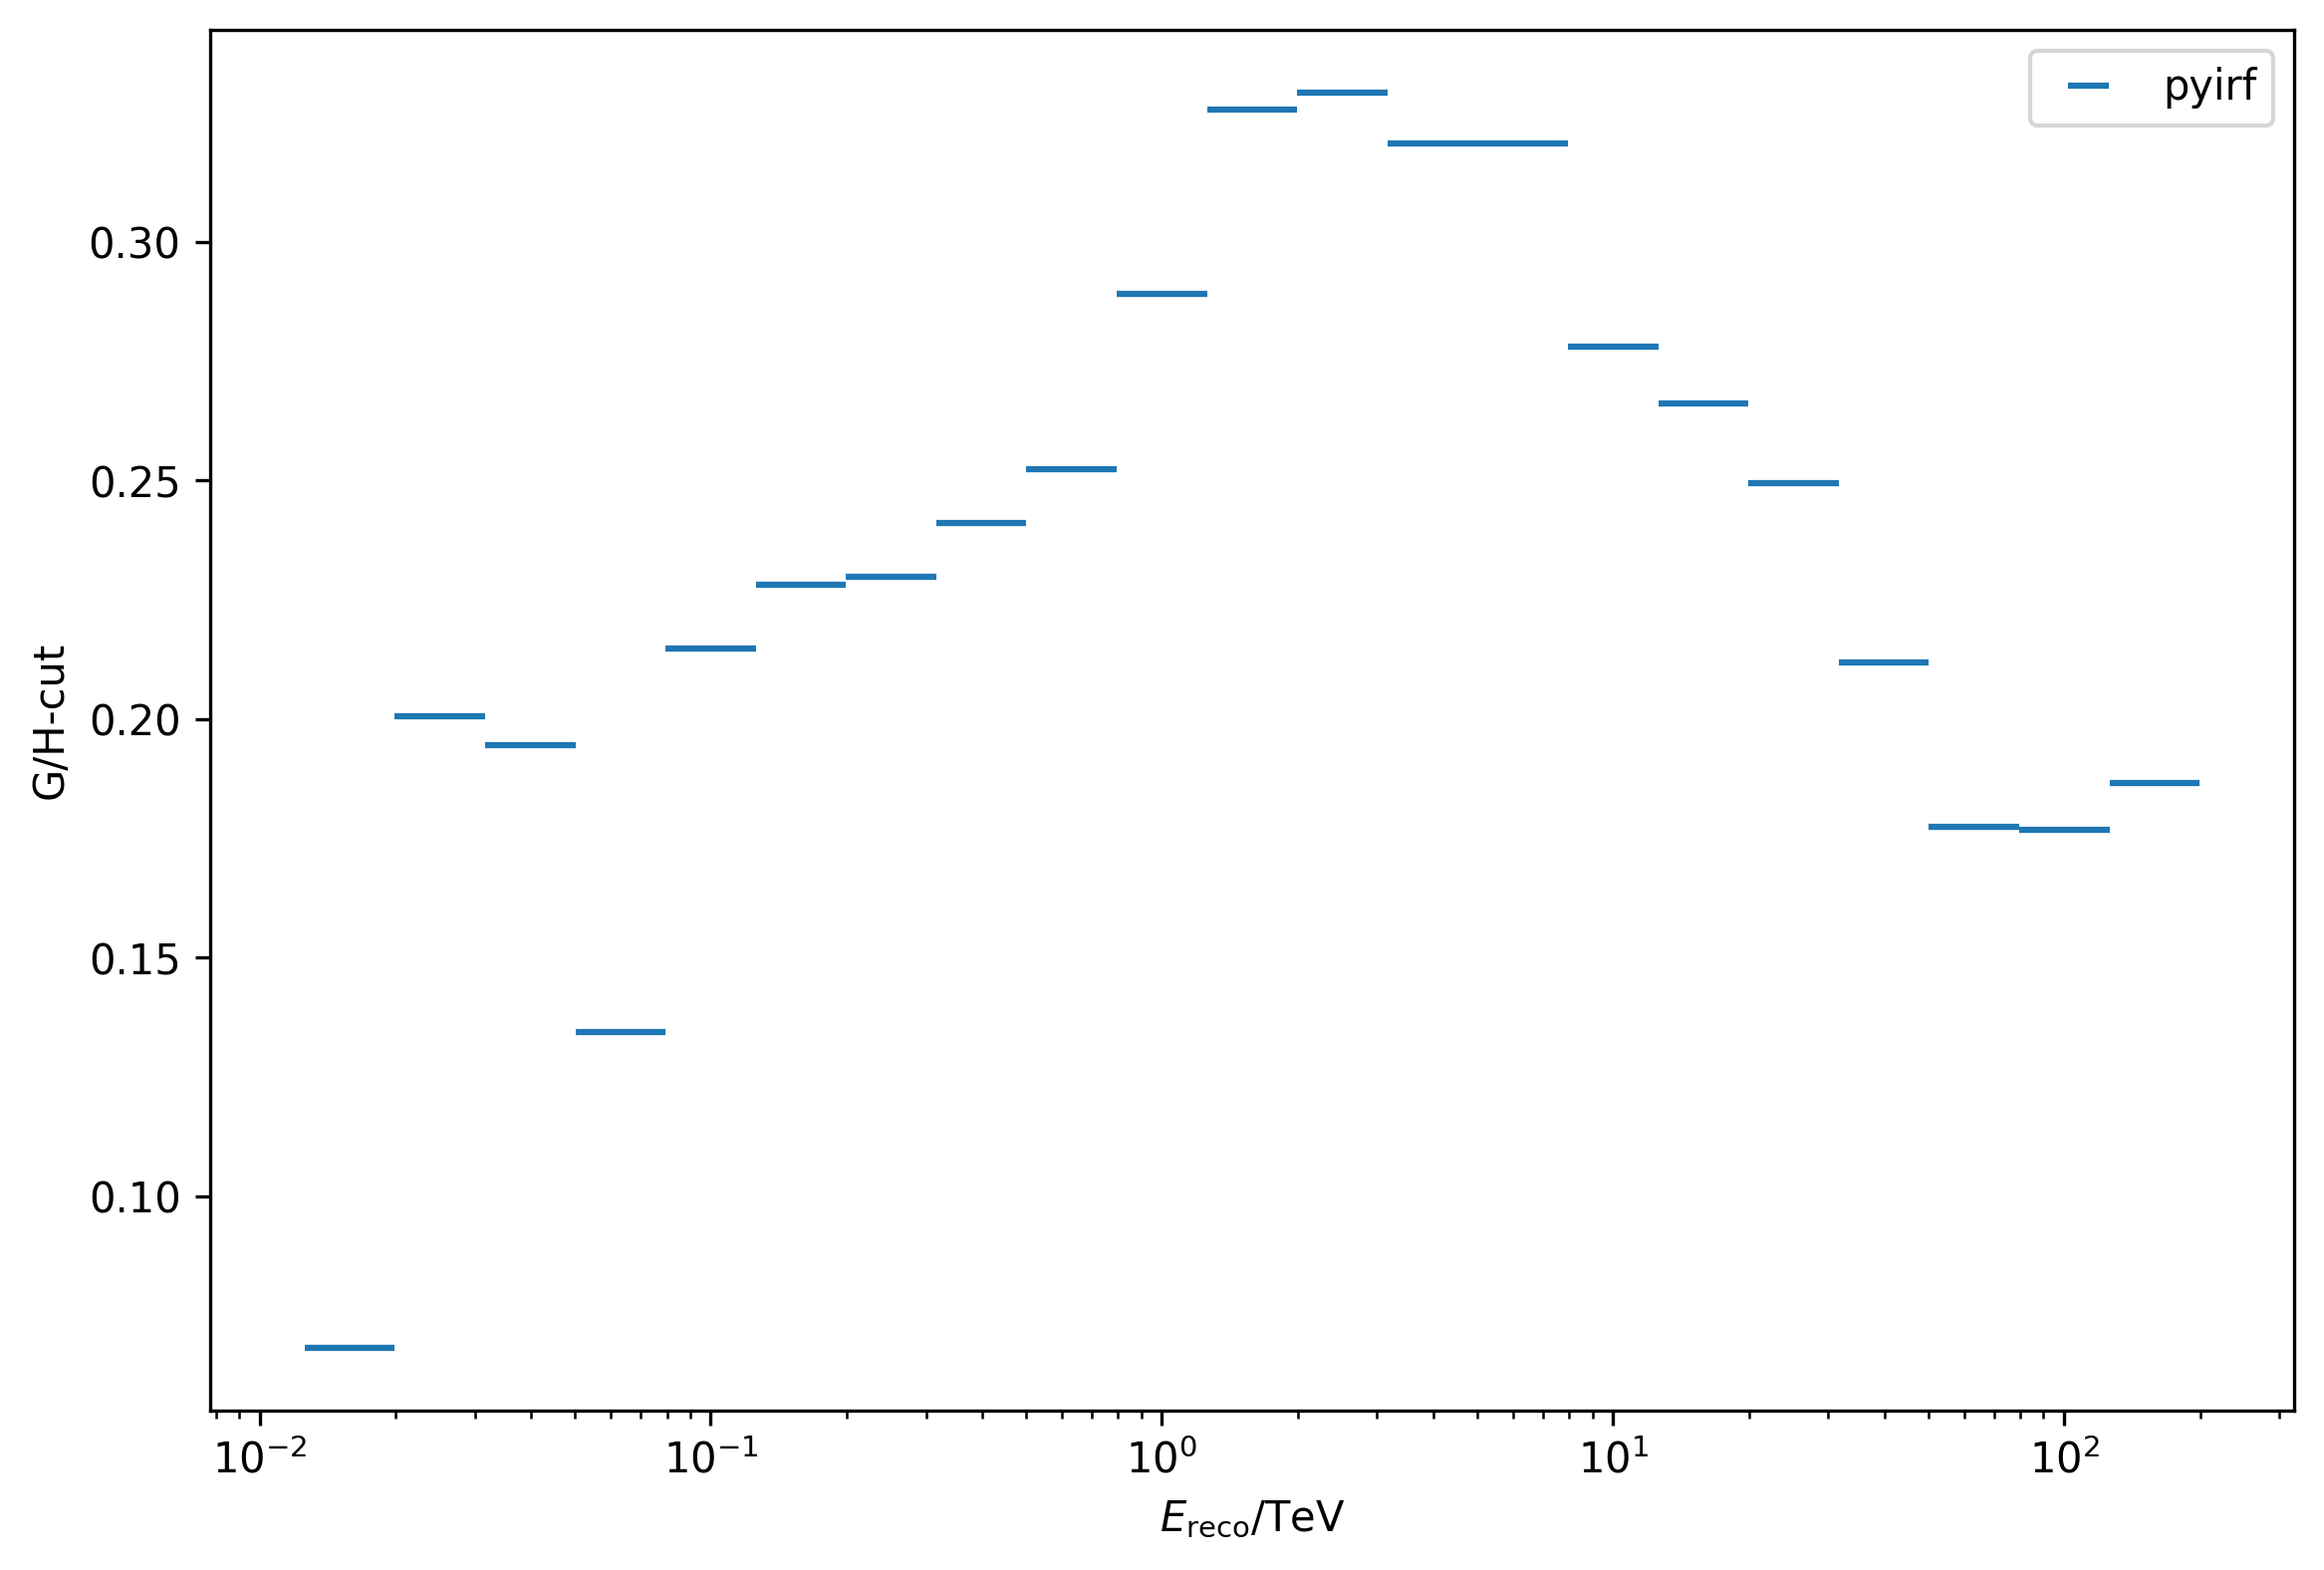

In [6]:
from astropy.table import QTable


gh_cut = QTable.read(pyirf_file, hdu='GH_CUTS')[1:-1]


plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='pyirf',
)

plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [7]:
# [1:-1] removes under/overflow bins
sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1]

# make it print nice
sensitivity['reco_energy_low'].info.format = '.3g'
sensitivity['reco_energy_high'].info.format = '.3g'
sensitivity['reco_energy_center'].info.format = '.3g'
sensitivity['relative_sensitivity'].info.format = '.2g'
sensitivity['flux_sensitivity'].info.format = '.3g'

for k in filter(lambda k: k.startswith('n_'), sensitivity.colnames):
    sensitivity[k].info.format = '.1f'

sensitivity

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,n_electron,n_electron_weighted,n_proton,n_proton_weighted,significance,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,,,,,,1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0126,0.02,0.0163,321.1,611.2,114.0,61070.0,21.0,6030.1,93.1,55039.9,5.00000000000191,0.084,1.16e-07
0.02,0.0316,0.0258,466.2,696.1,225.0,69613.1,140.1,27815.4,84.9,41797.7,5.334366133300075,0.034,1.39e-08
0.0316,0.0501,0.0409,695.6,840.7,358.9,84074.3,256.9,35211.9,102.0,48862.5,5.862315649056272,0.018,2.24e-09
0.0501,0.0794,0.0648,628.9,591.4,289.9,57141.7,198.6,17308.6,91.3,39833.1,5.000000000001035,0.0071,2.62e-10
0.0794,0.126,0.103,525.3,367.0,221.7,21743.8,191.1,10548.7,30.5,11195.1,5.000000000000102,0.0042,4.63e-11
0.126,0.2,0.163,428.4,223.5,128.8,7895.1,117.0,4160.2,11.8,3734.9,5.000000000000102,0.0033,1.09e-11
0.2,0.316,0.258,351.6,138.5,81.6,2934.3,76.6,1754.3,5.0,1180.0,5.000000000002407,0.0028,2.77e-12
0.316,0.501,0.409,282.6,84.2,47.2,1023.9,44.9,637.5,2.2,386.4,5.000000000071256,0.0027,7.86e-13


<Figure size 3600x2400 with 0 Axes>

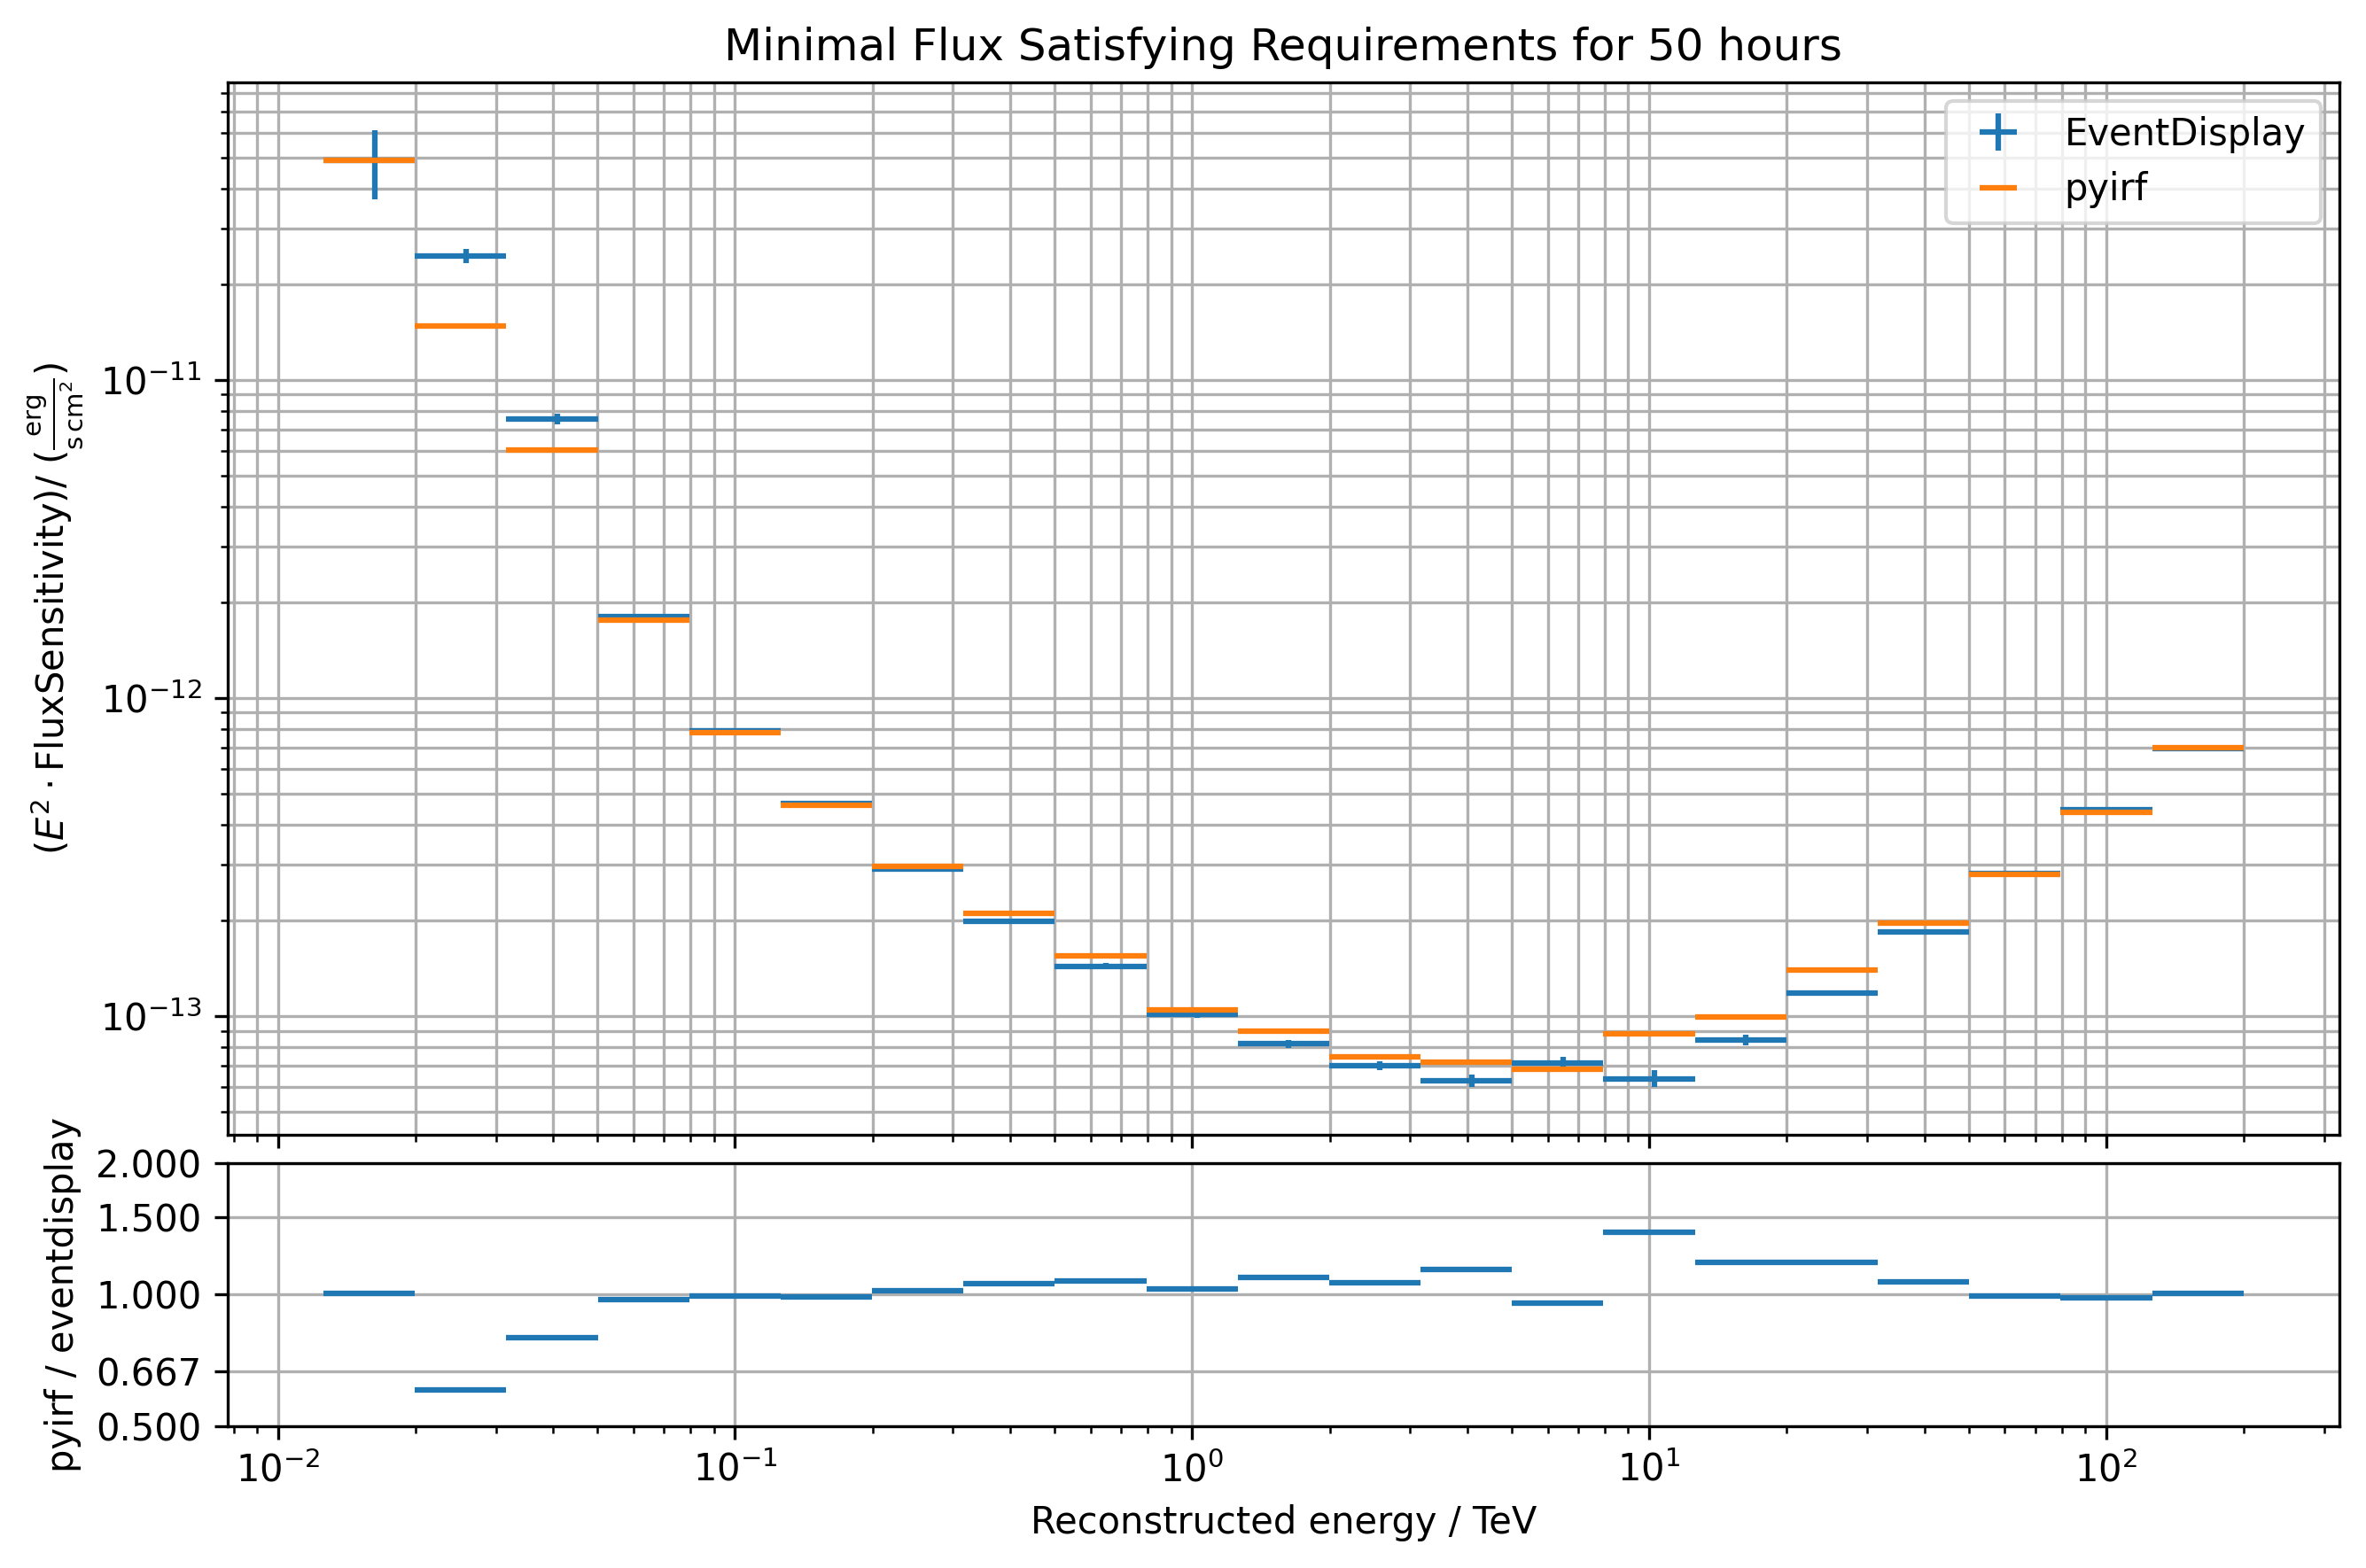

In [8]:
plt.figure(figsize=(12,8))

# Get data from event display file
y, edges = irf_eventdisplay["DiffSens"].to_numpy()
yerr = irf_eventdisplay["DiffSens"].errors()
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)

fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [4, 1]},
    sharex=True,
)

ax_sens.errorbar(
    x,
    y, 
    xerr=width/2,
    yerr=yerr,
    label="EventDisplay",
    ls=''
)

unit = u.Unit('erg cm-2 s-1')


e = sensitivity['reco_energy_center']
w = (sensitivity['reco_energy_high'] - sensitivity['reco_energy_low'])
s = (e**2 * sensitivity['flux_sensitivity'])


ax_sens.errorbar(
    e.to_value(u.TeV),
    s.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='pyirf'
)

ax_ratio.errorbar(
    e.to_value(u.TeV), s.to_value(unit) / y,
    xerr=w.to_value(u.TeV)/2,
    ls=''
)
ax_ratio.set_yscale('log')
ax_ratio.set_xlabel("Reconstructed energy / TeV")
ax_ratio.set_ylabel('pyirf / eventdisplay')
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())

ax_ratio.set_ylim(0.5, 2.0)
ax_ratio.set_yticks([0.5, 2/3, 1, 3/2, 2])
ax_ratio.set_yticks([], minor=True)

# Style settings
ax_sens.set_title('Minimal Flux Satisfying Requirements for 50 hours')
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)


None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

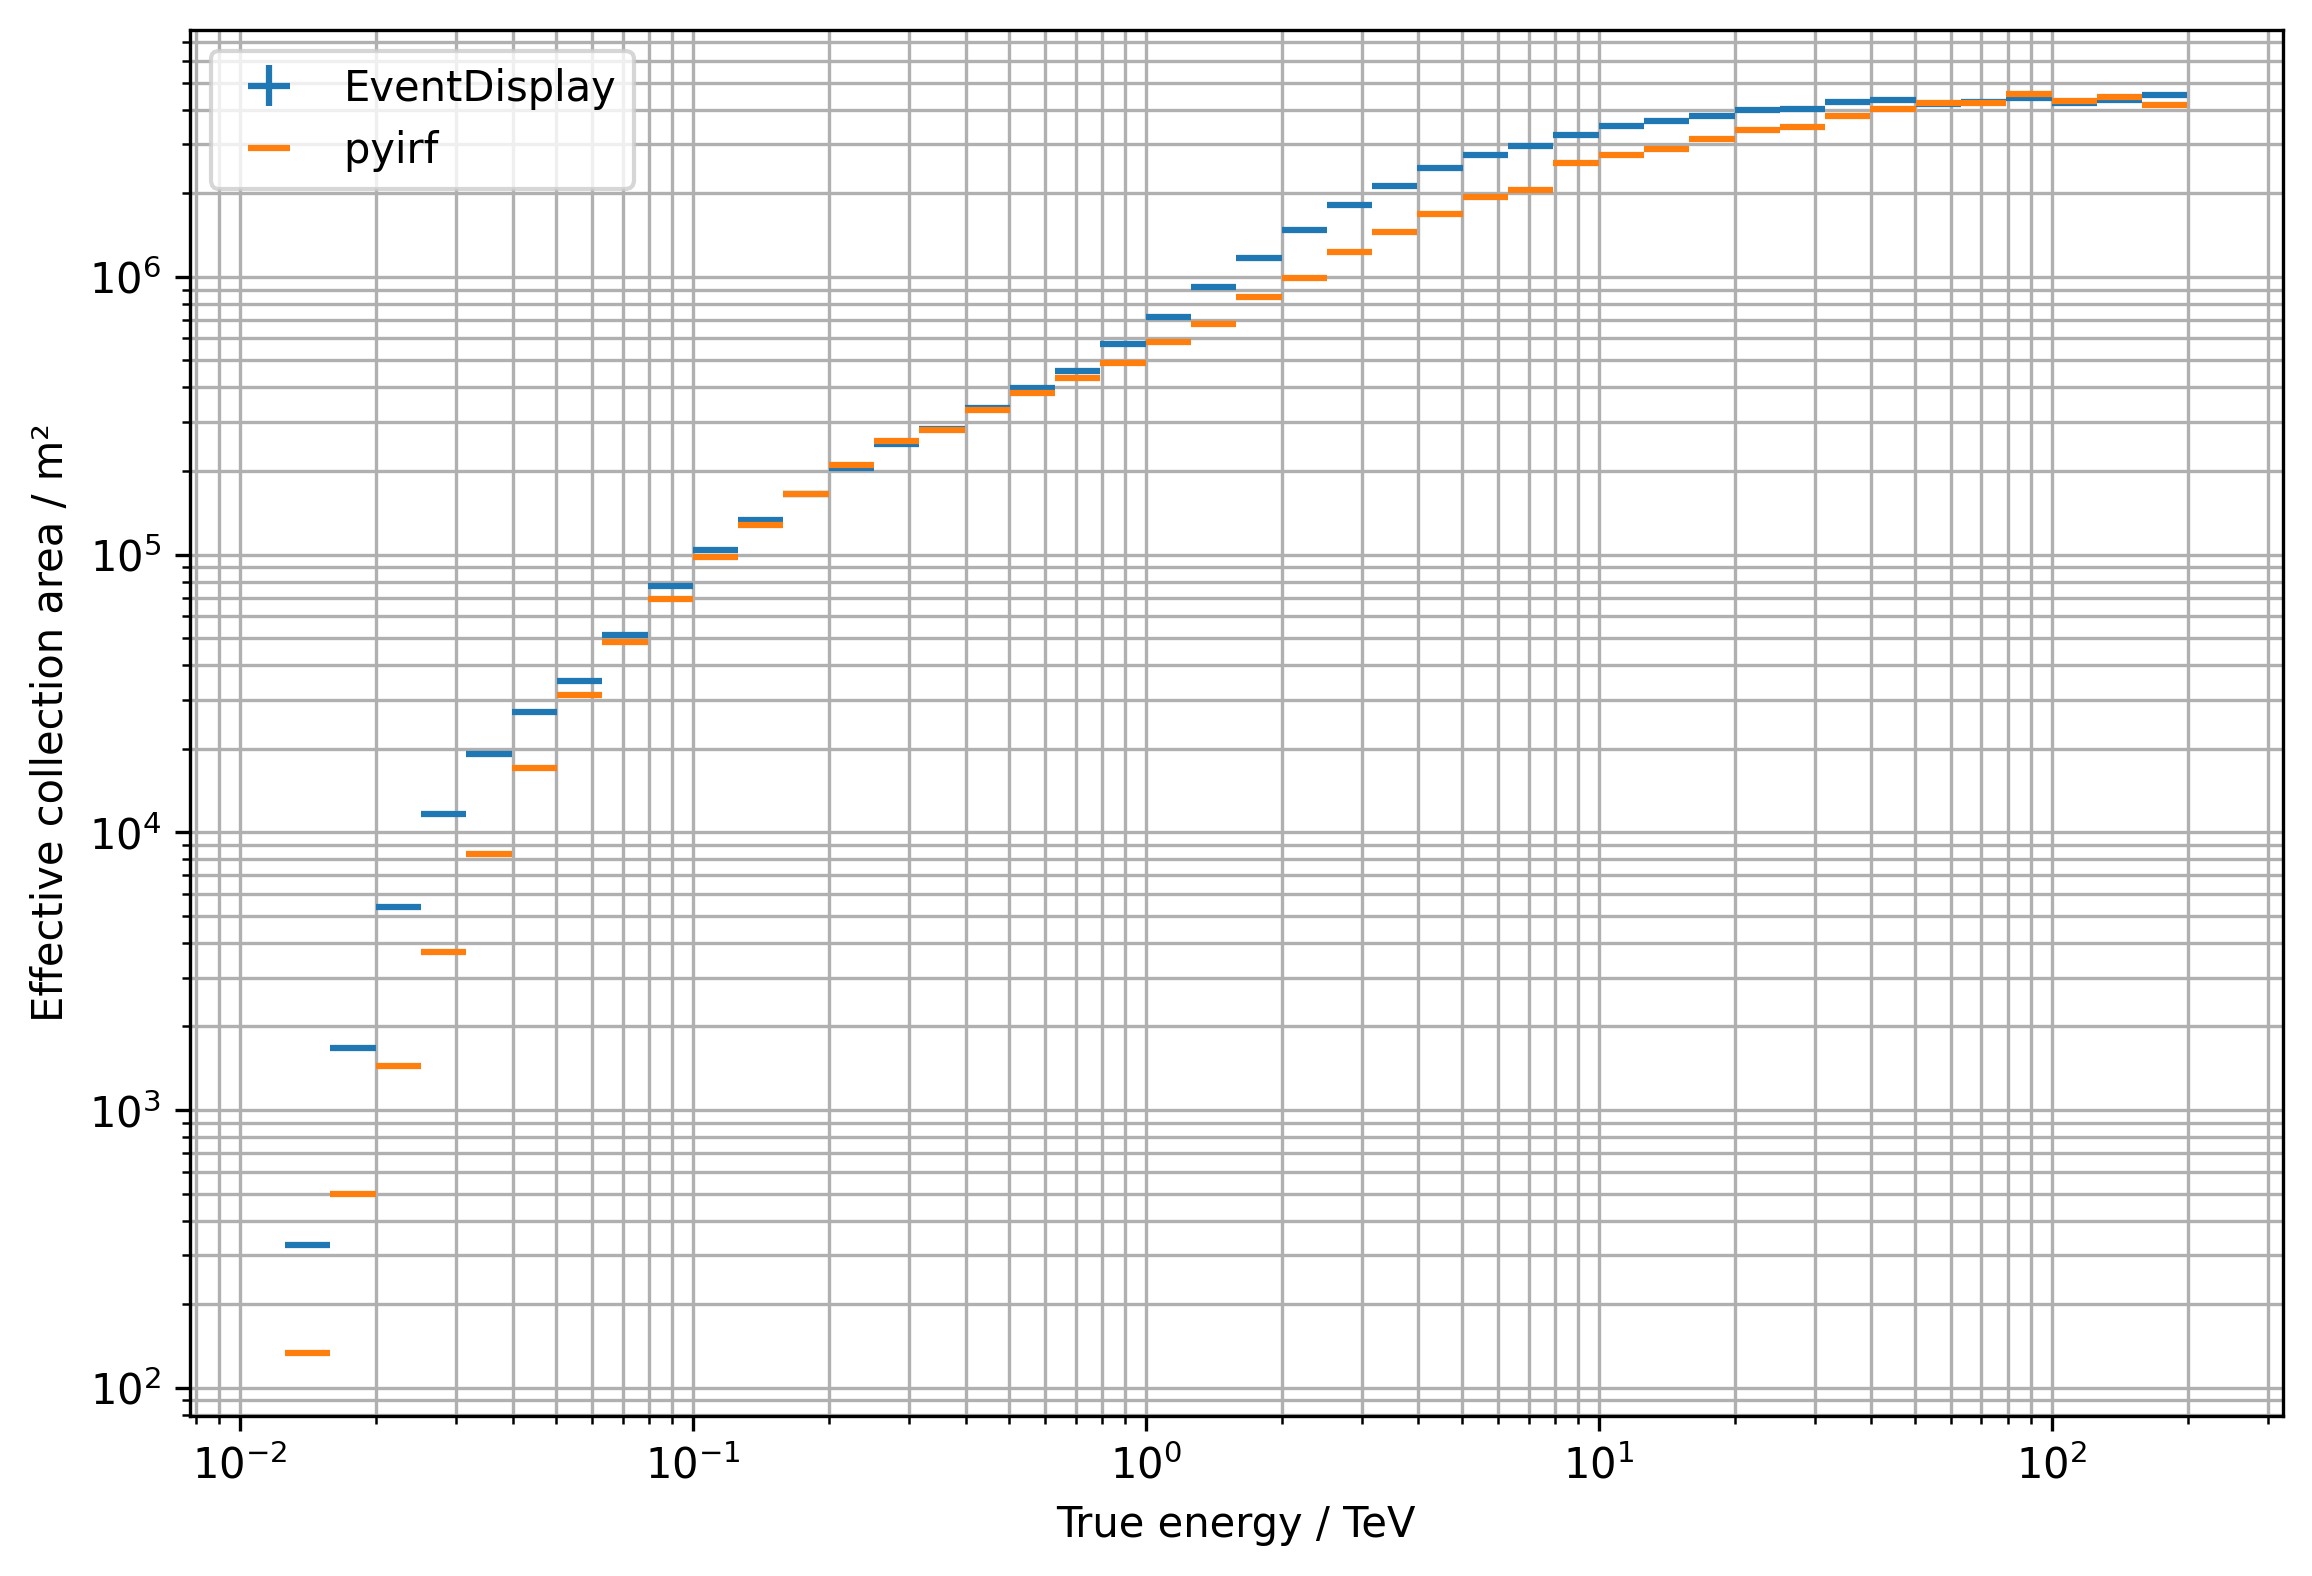

In [9]:

# Data from EventDisplay
y, edges = irf_eventdisplay["EffectiveAreaEtrue"].to_numpy()
yerr = irf_eventdisplay["EffectiveAreaEtrue"].errors()

x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# uncomment the other strings to see effective areas
# for the different cut levels. Left out here for better
# visibility of the final effective areas.
suffixes = [
    ''
#     '_NO_CUTS',
#     '_ONLY_GH',
#     '_ONLY_THETA',
]

for suffix in suffixes: 
    area = QTable.read(pyirf_file, hdu='EFFECTIVE_AREA' + suffix)[0]
   
    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label='pyirf ' + suffix,
    )

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

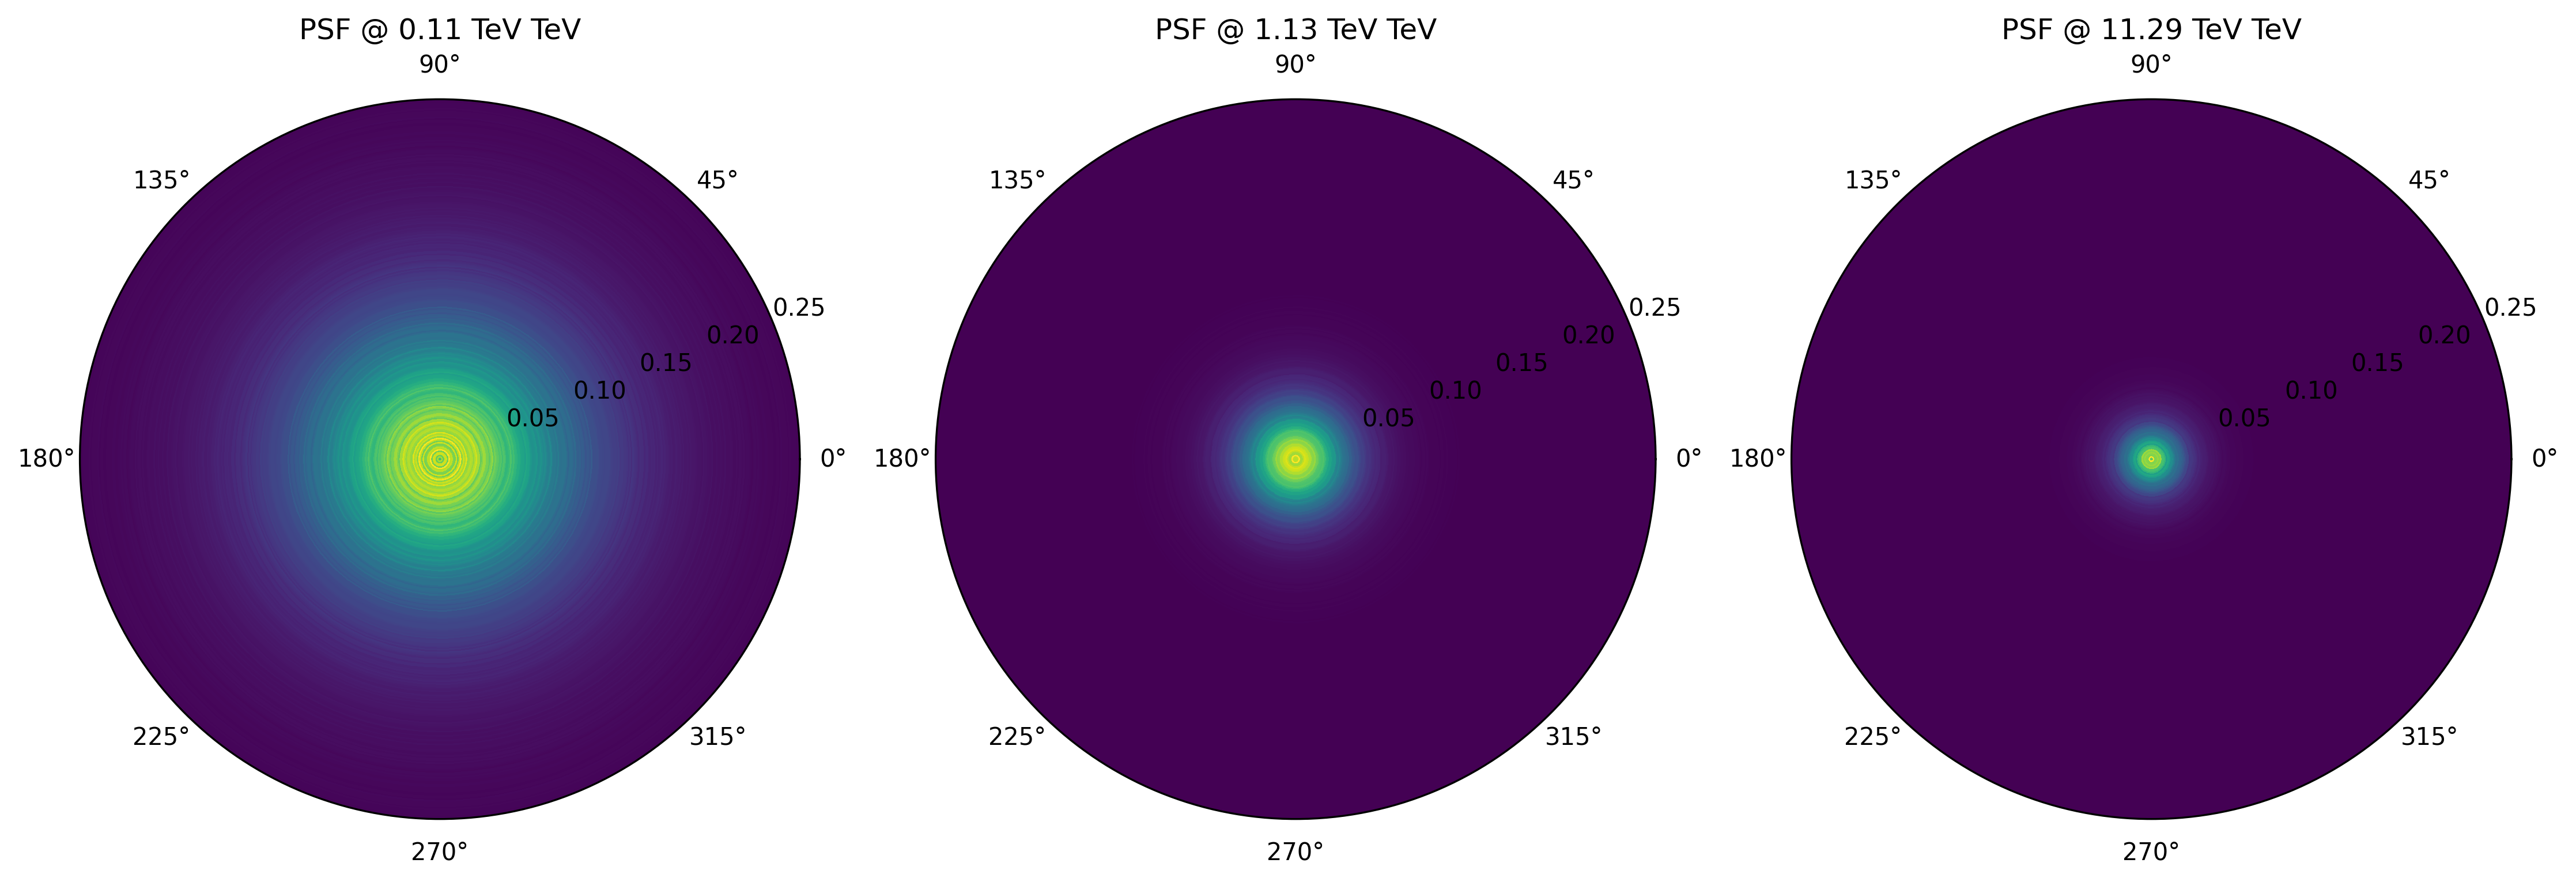

In [10]:
psf_table = QTable.read(pyirf_file, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)



# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects

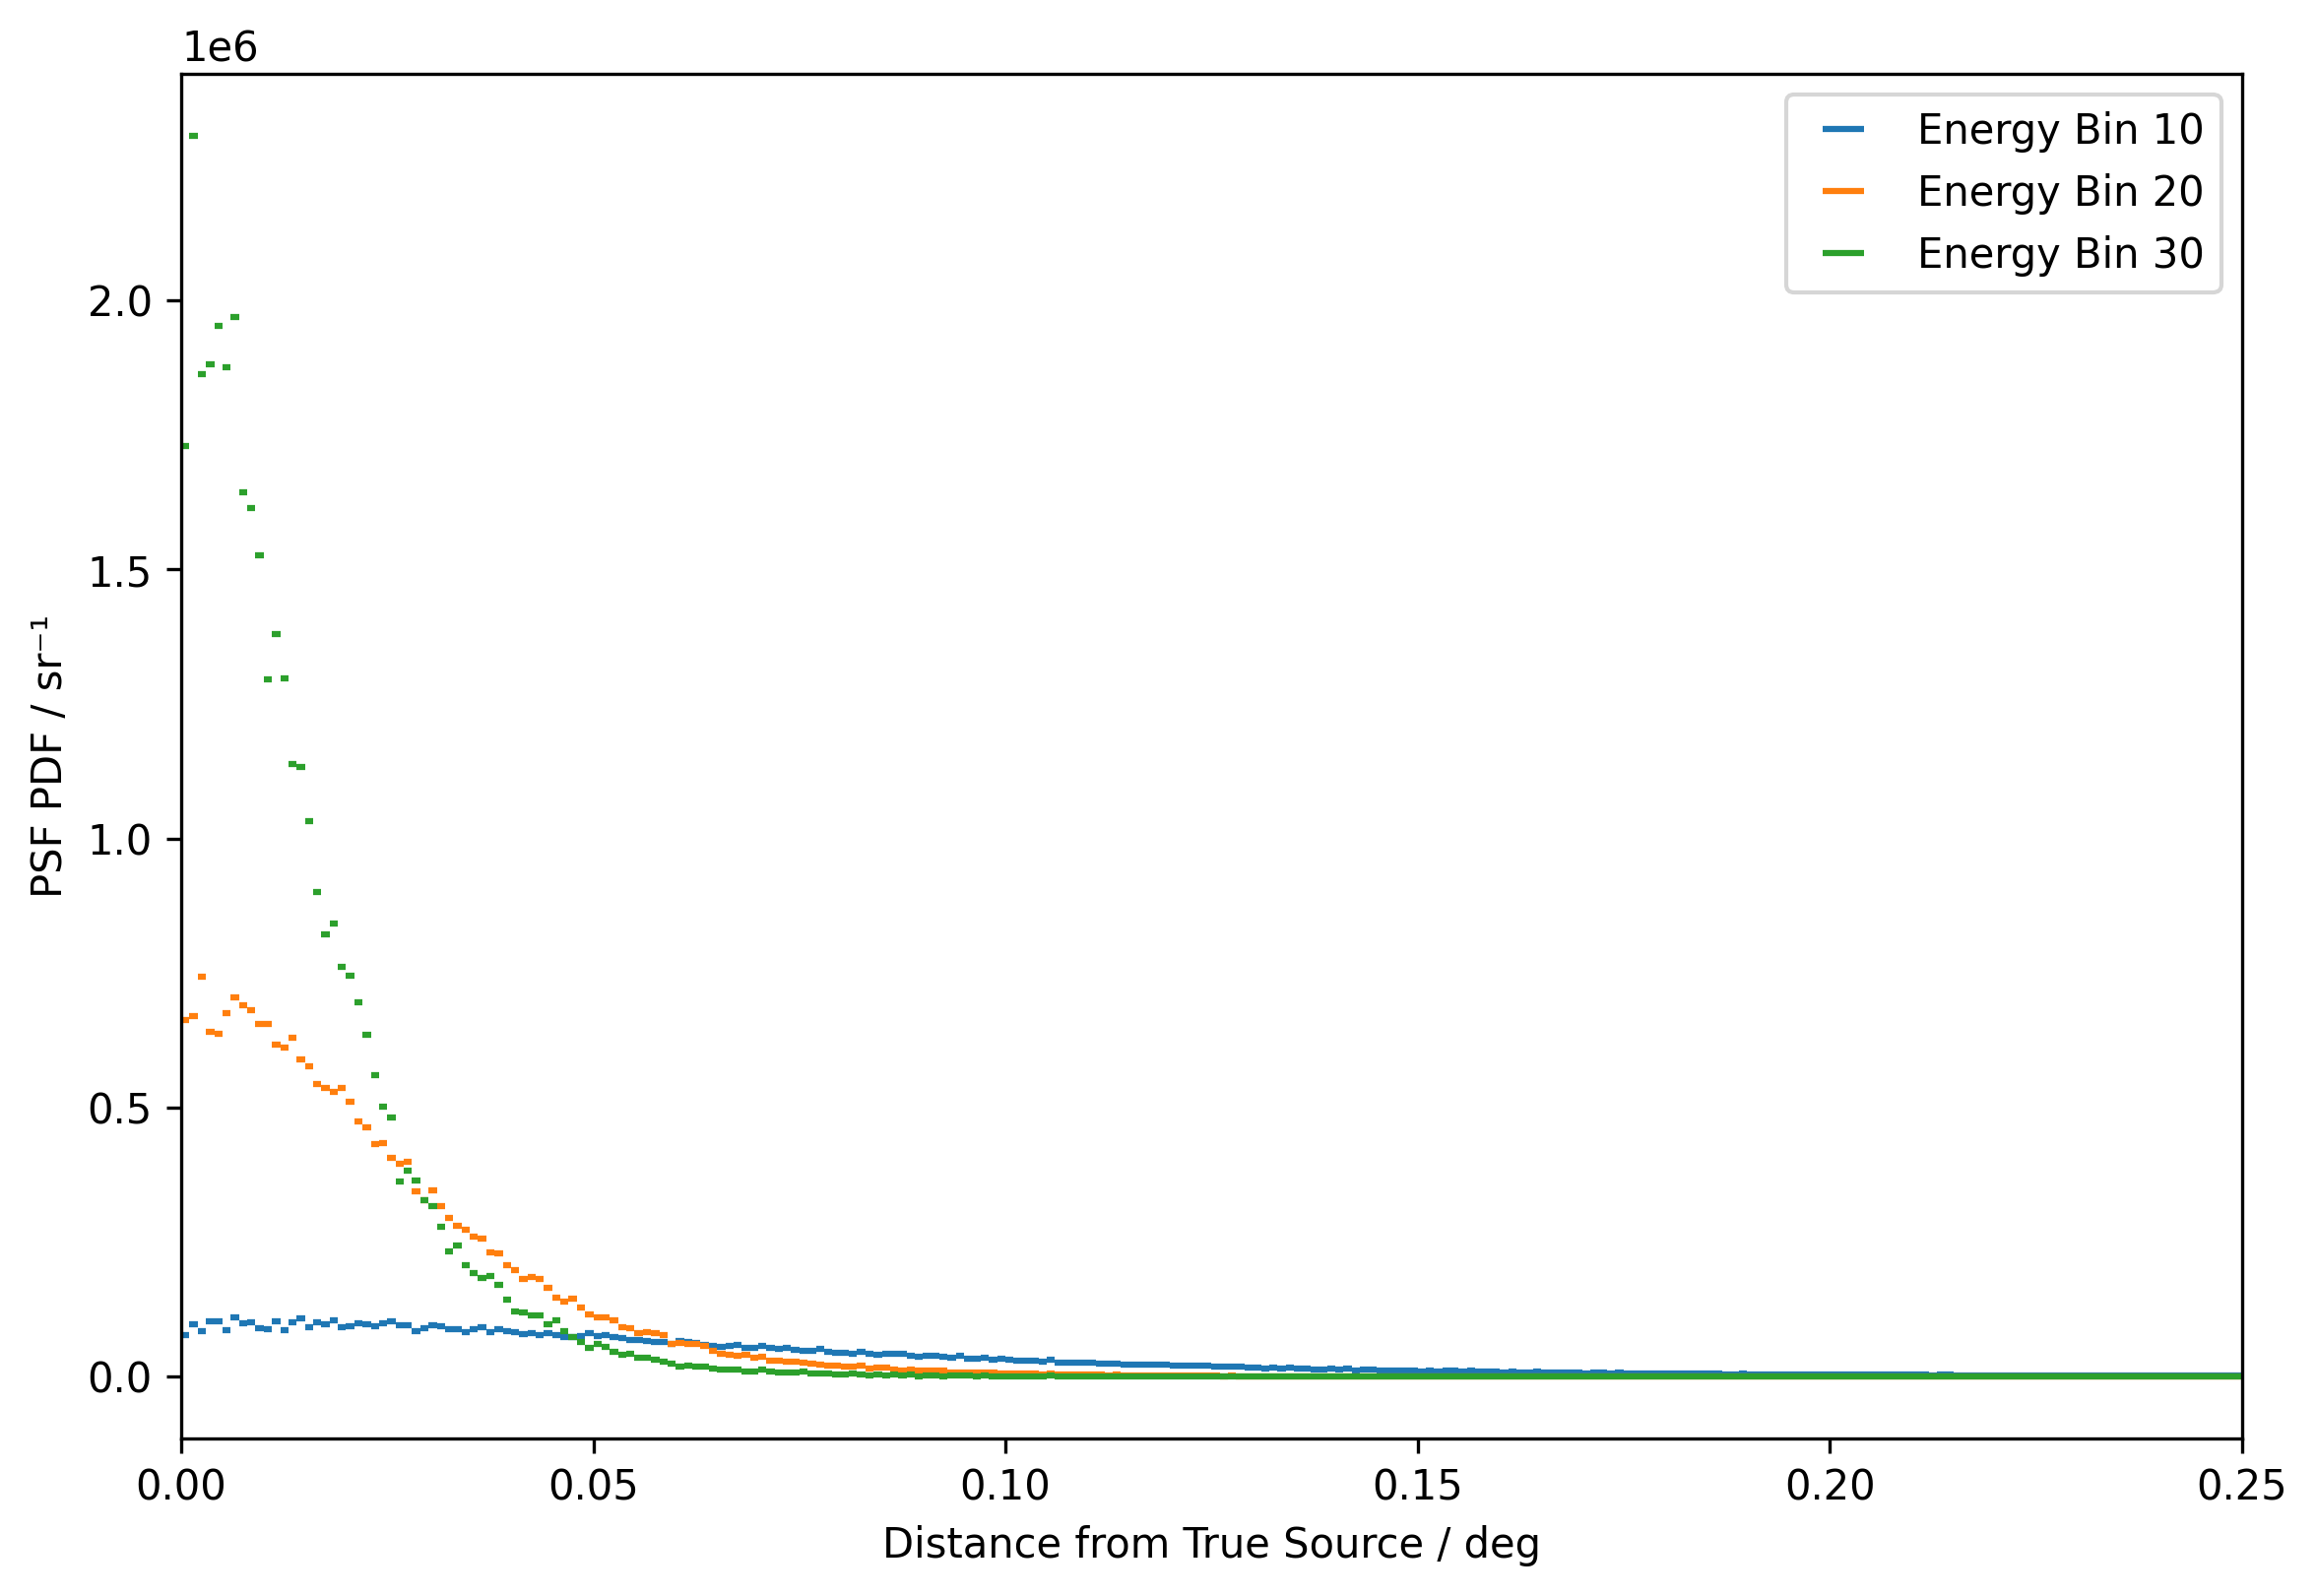

In [11]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF / sr⁻¹')
plt.xlabel('Distance from True Source / deg')

None # to remove clutter by mpl objects

#### Angular resolution
[back to top](#Table-of-contents)

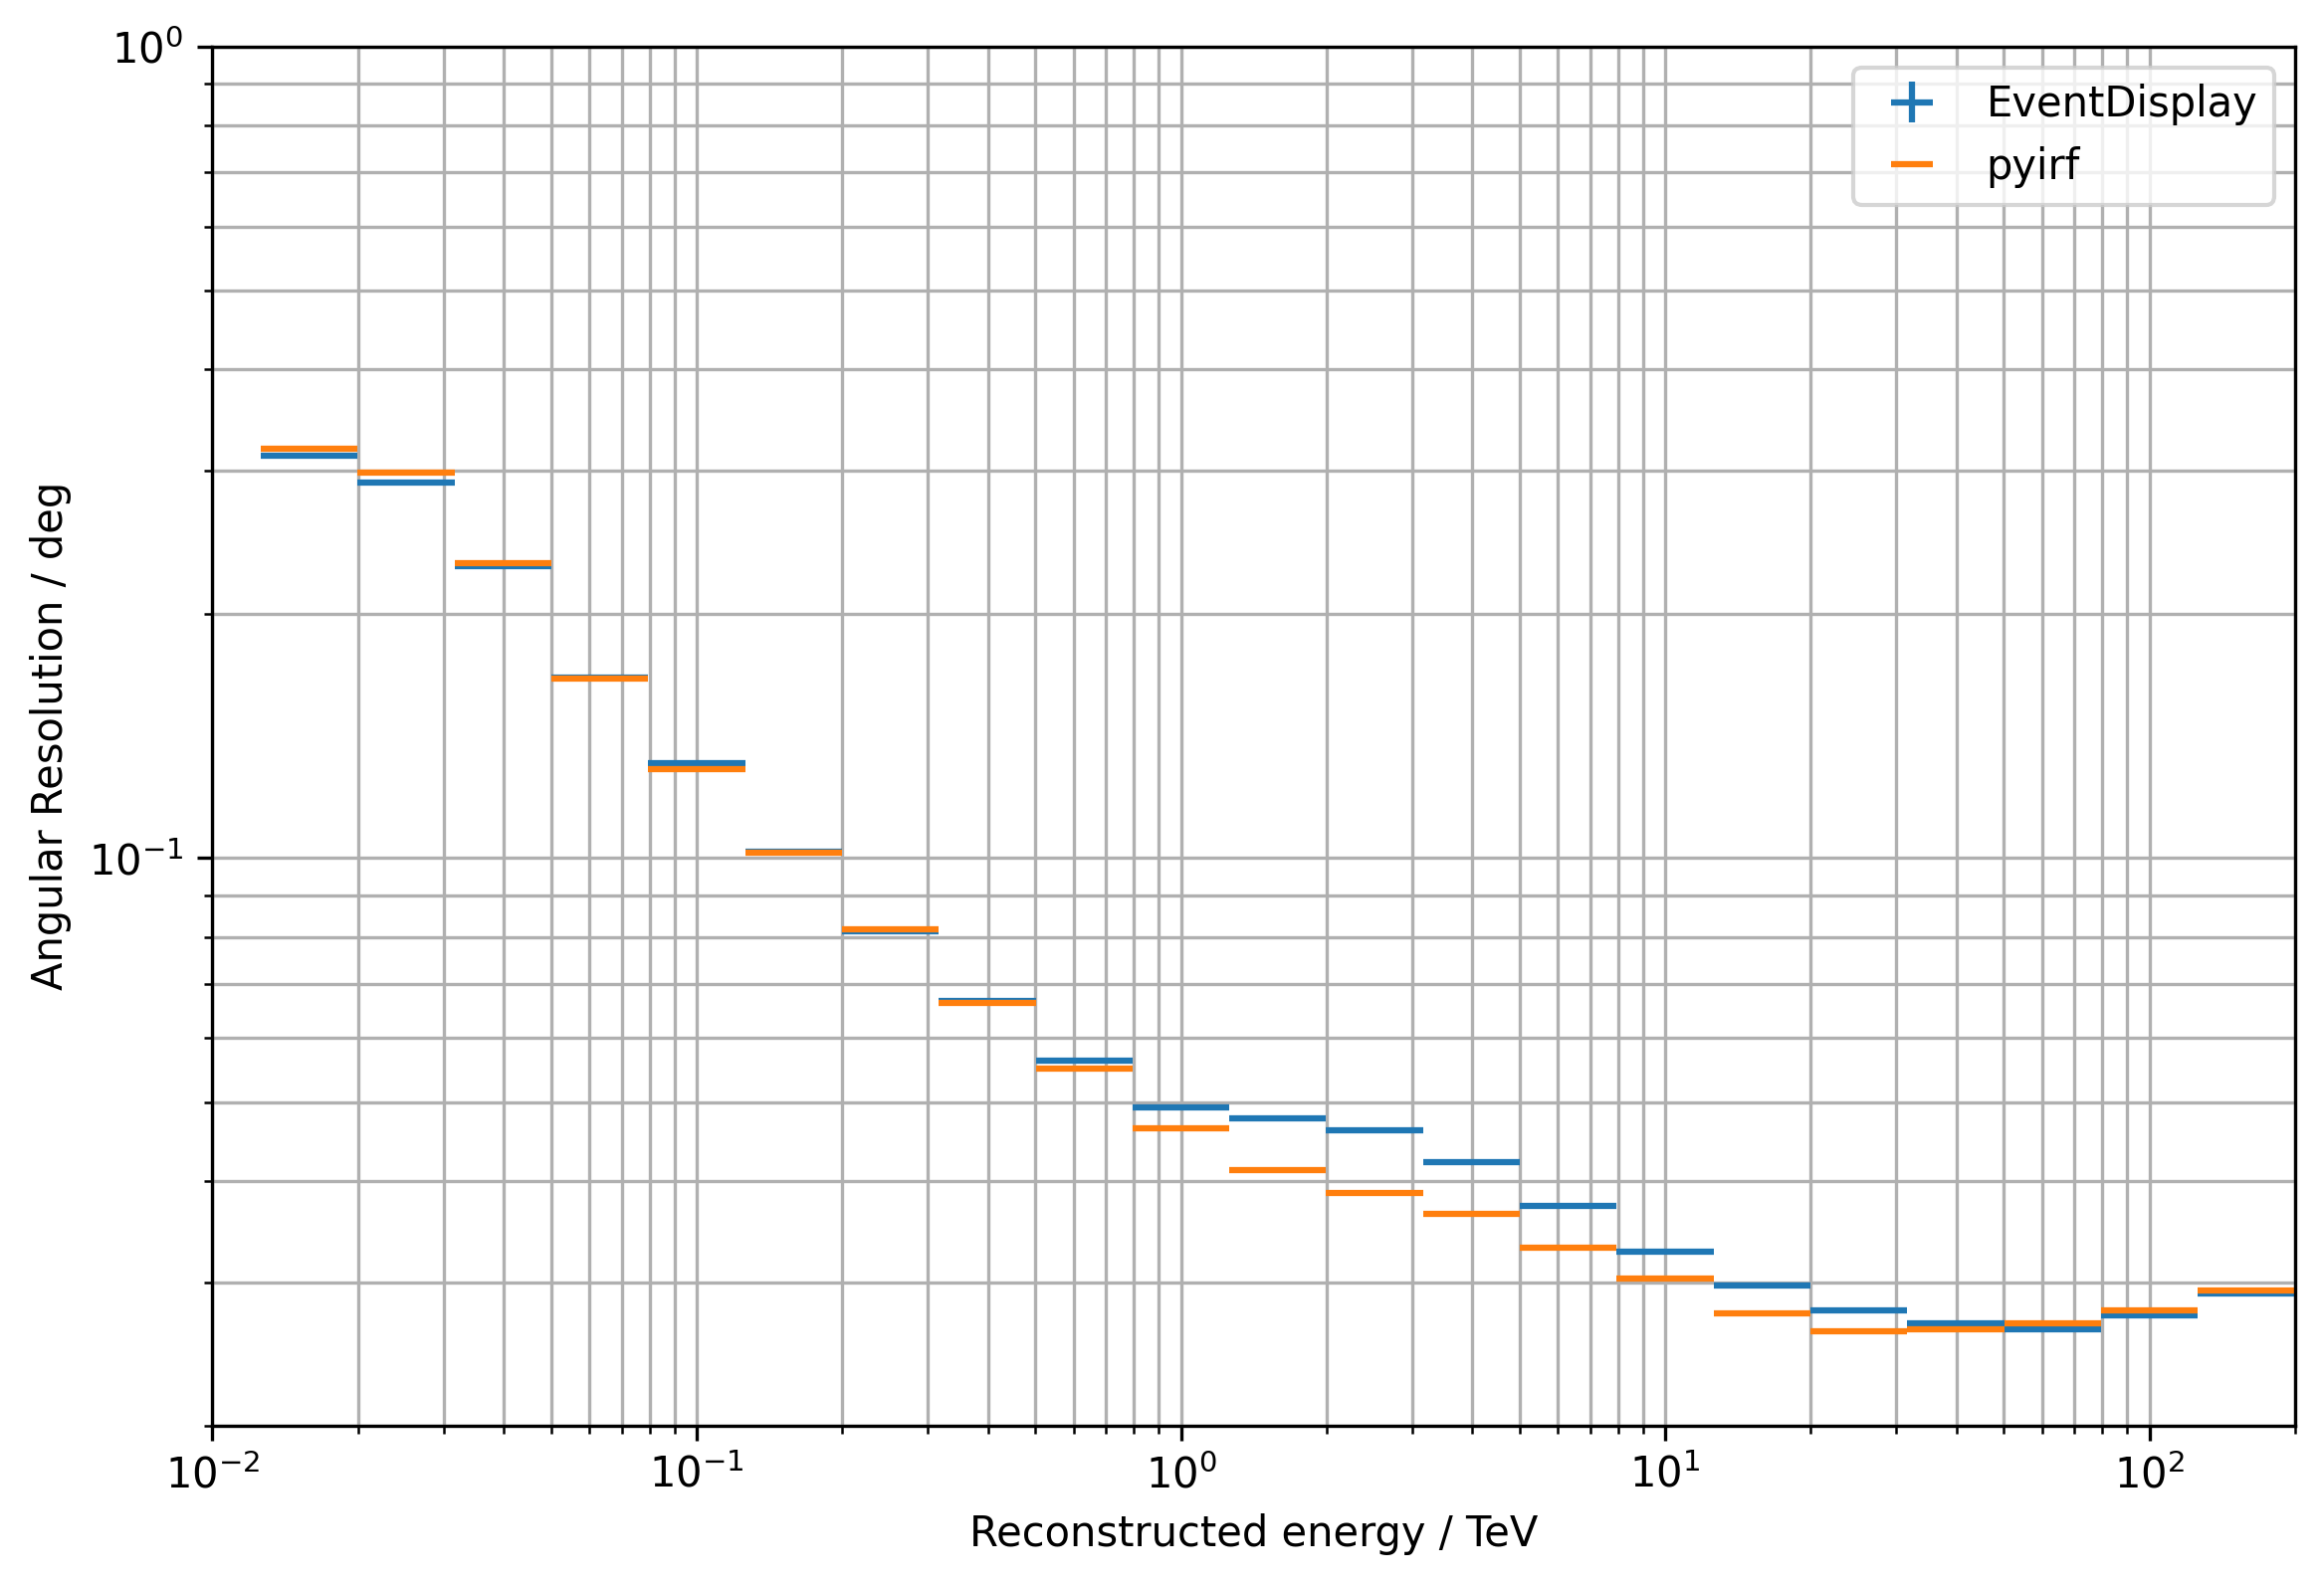

In [12]:
# Data from EventDisplay
y, edges = irf_eventdisplay["AngRes"].to_numpy()
yerr = irf_eventdisplay["AngRes"].errors()

x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# pyirf

ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
)


# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(2.e-2, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

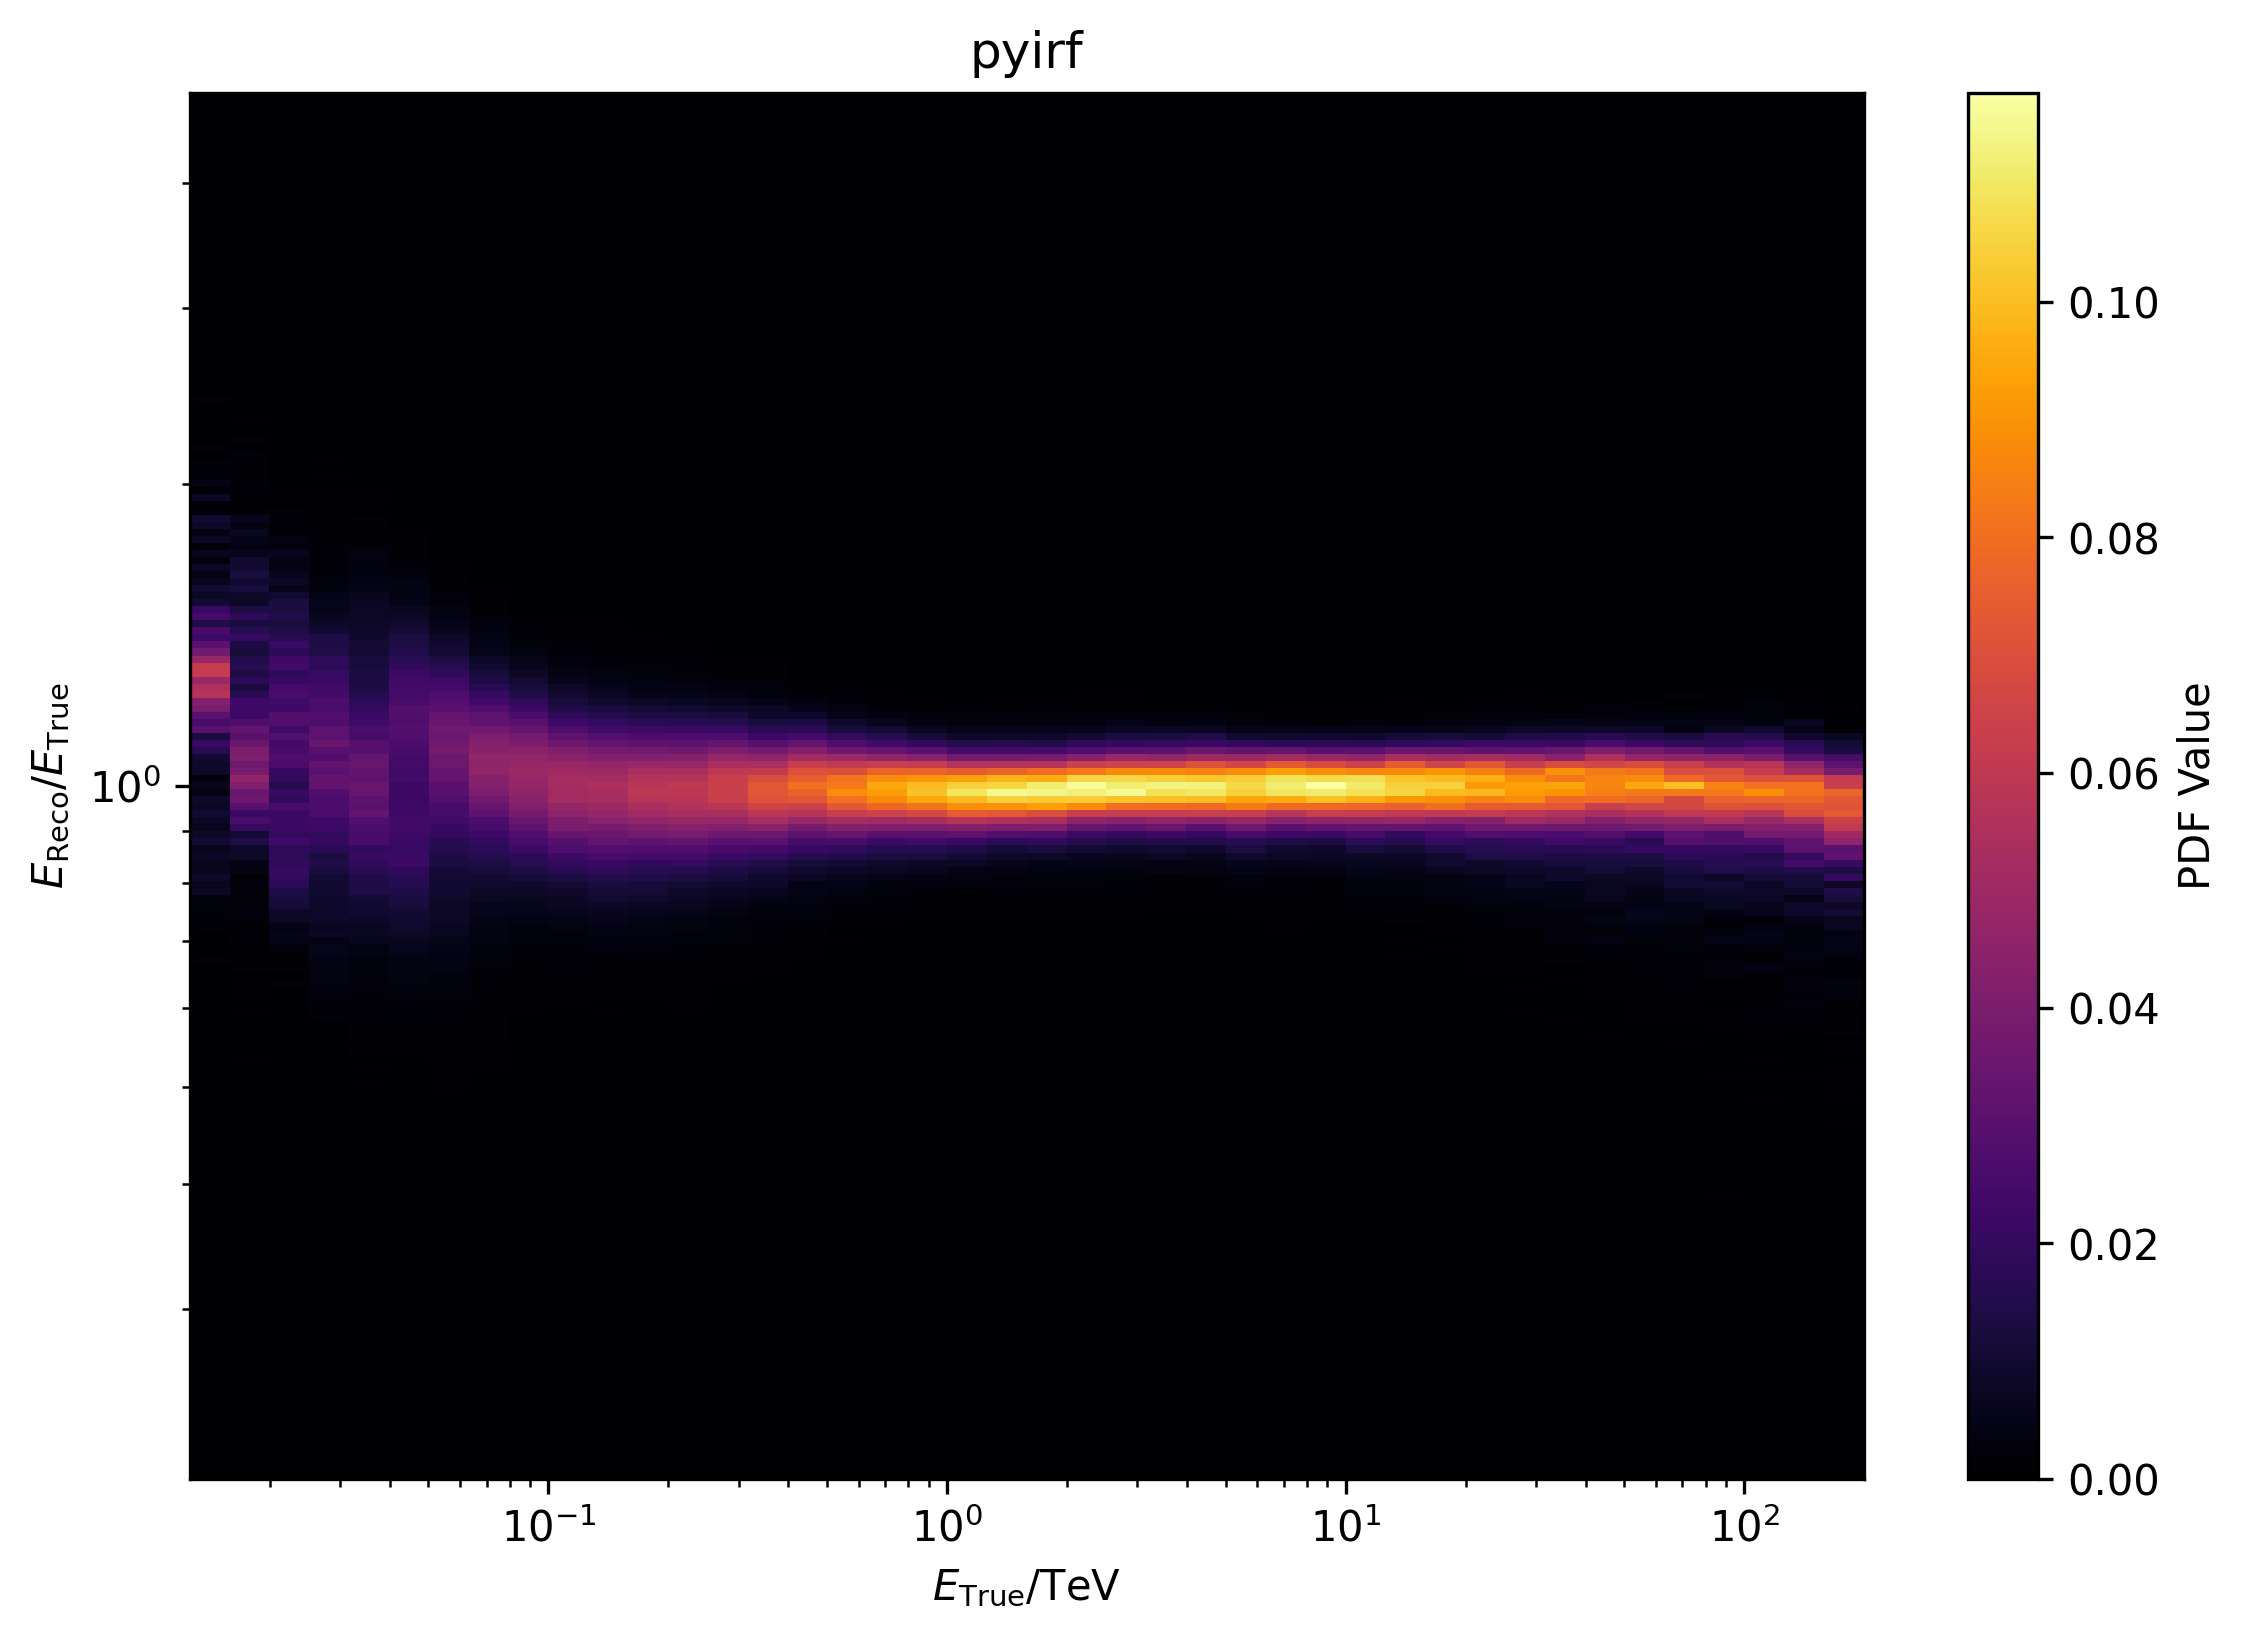

In [13]:
edisp = QTable.read(pyirf_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title('pyirf')
plt.pcolormesh(e_bins.to_value(u.TeV), migra_bins, edisp['MATRIX'].T[1:-1, 1:-1, 0].T, cmap='inferno')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='PDF Value')

plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')

None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

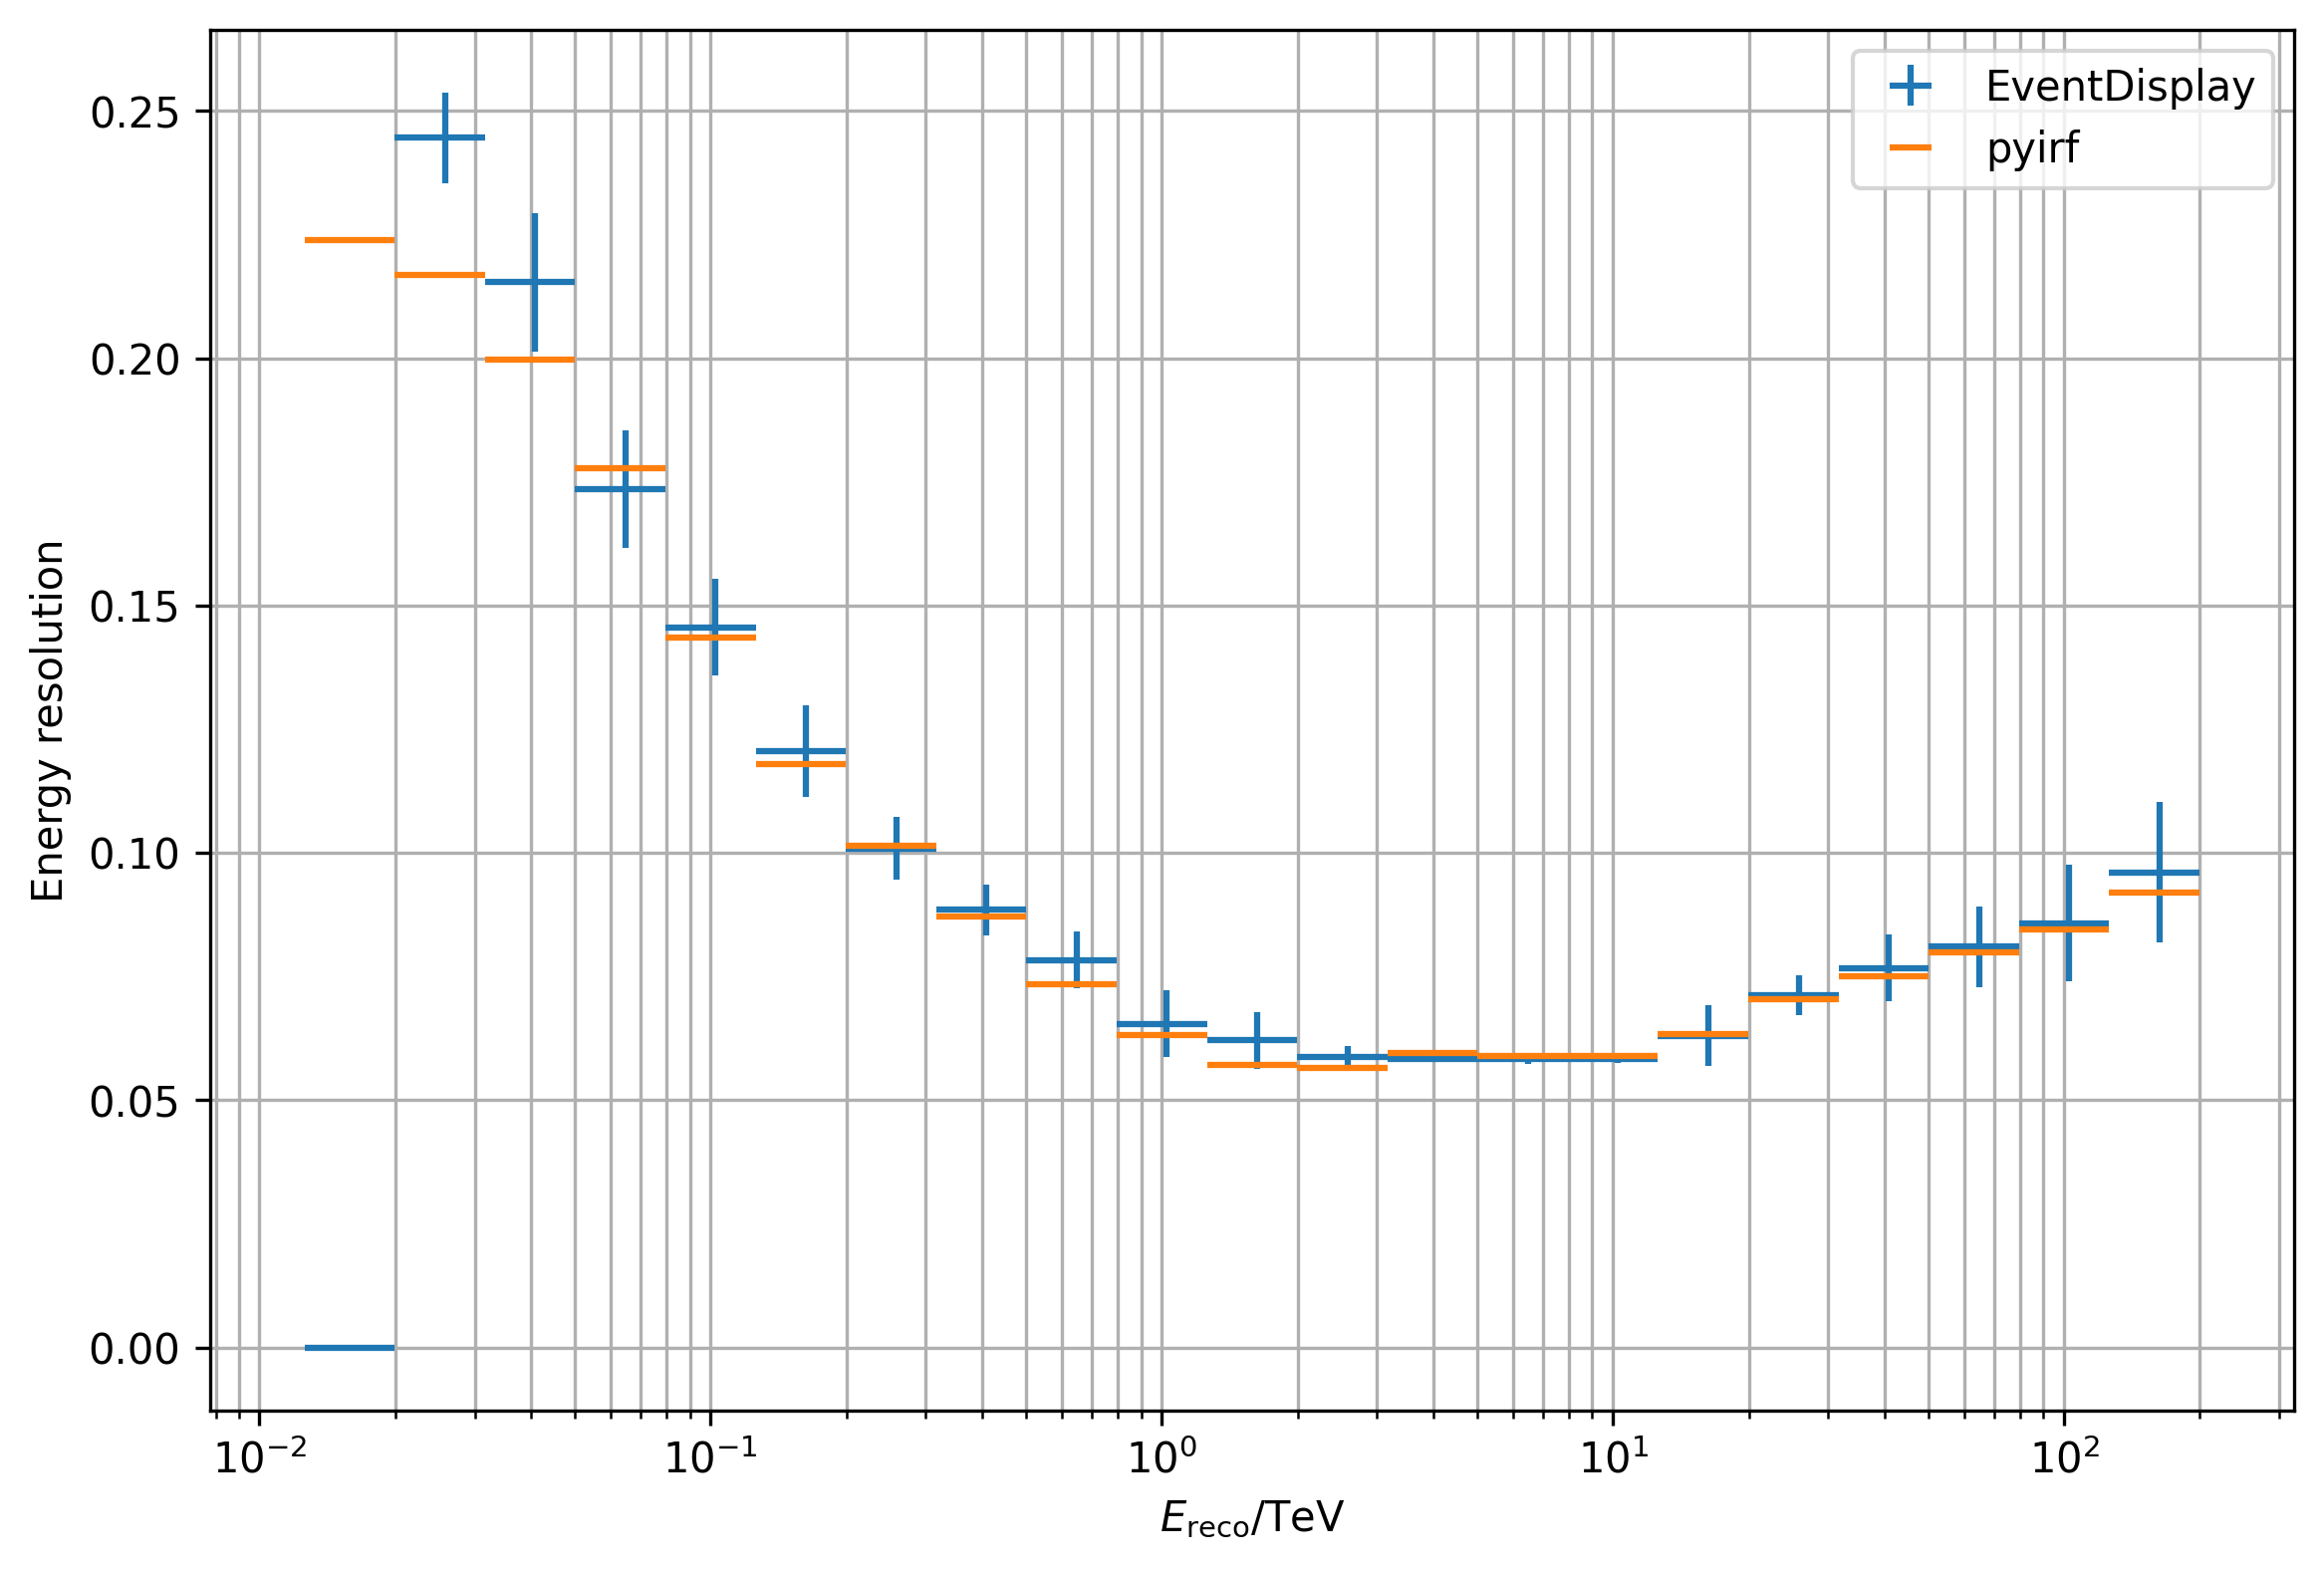

In [14]:
# Data from EventDisplay
y, edges = irf_eventdisplay["ERes"].to_numpy()
yerr = irf_eventdisplay["ERes"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2


# Data from pyirf
bias_resolution = QTable.read(pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]

# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")
plt.errorbar(
    0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
)
plt.xscale('log')

# Style settings
plt.xlabel(r"$E_\mathrm{reco} / \mathrm{TeV}$")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

/usr/local/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


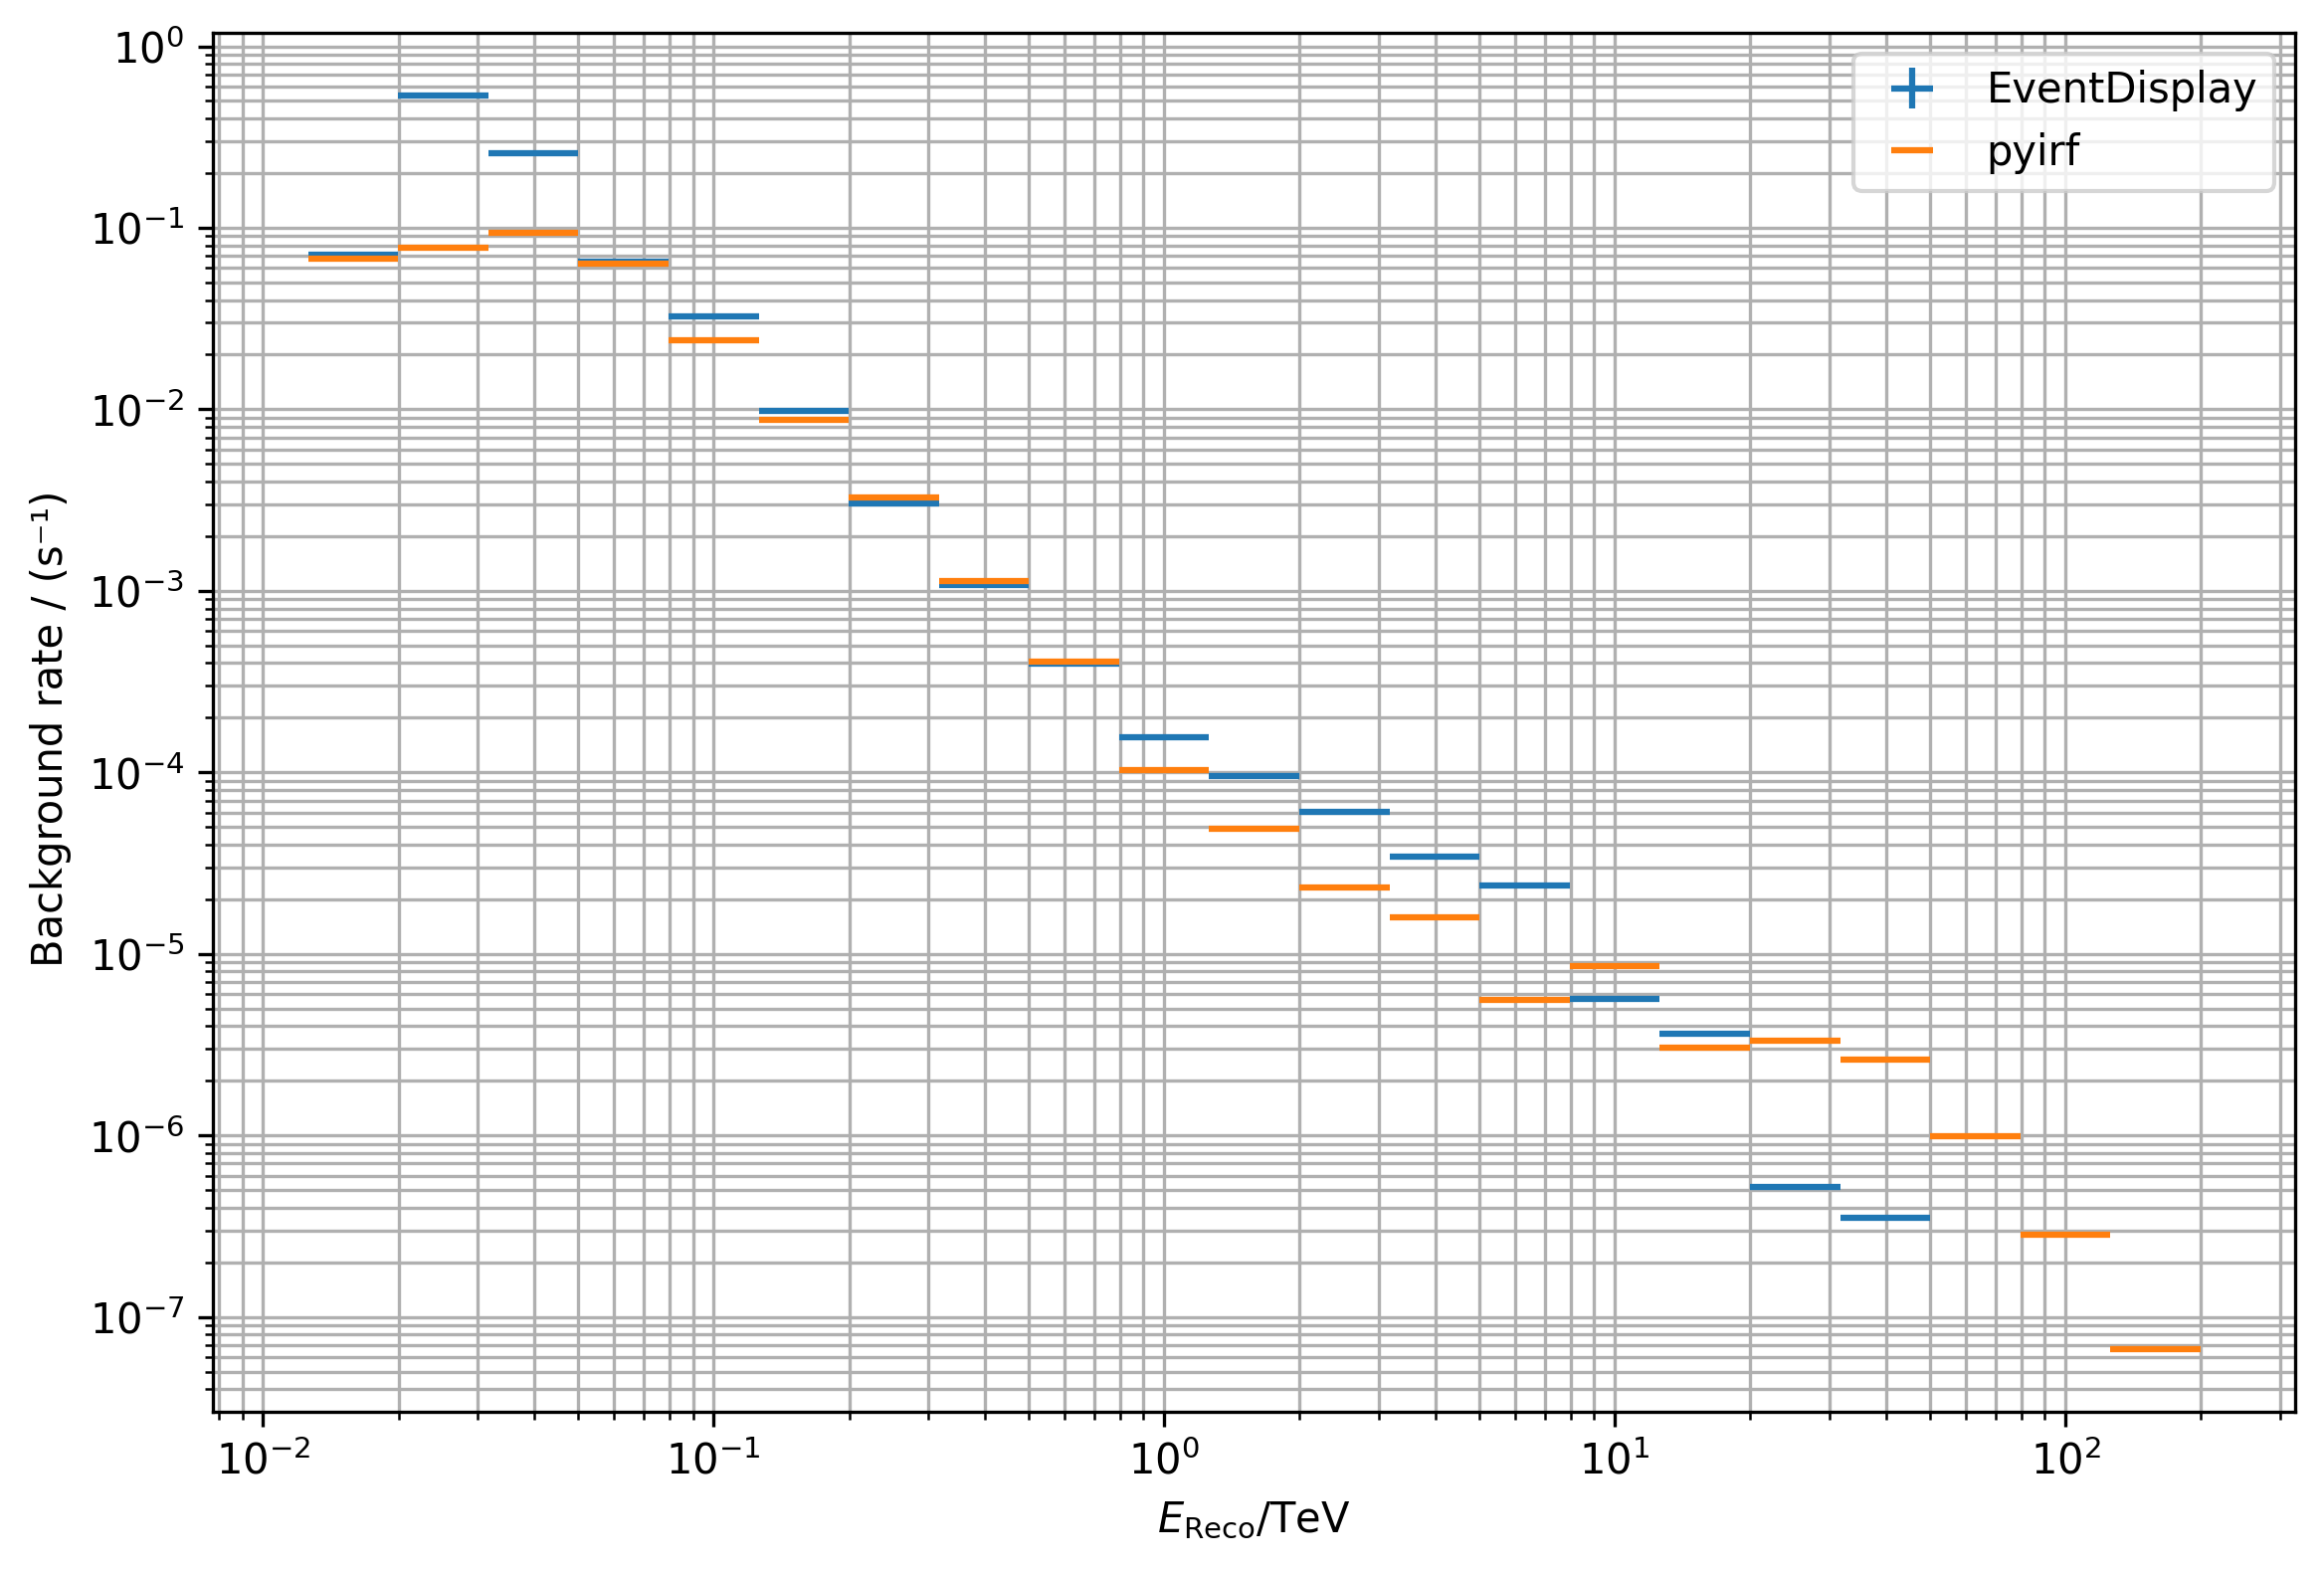

In [15]:
from pyirf.utils import cone_solid_angle

# Data from EventDisplay
y, edges = irf_eventdisplay["BGRate"].to_numpy()
yerr = irf_eventdisplay["BGRate"].errors()
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2

# pyirf data

bg_rate = QTable.read(pyirf_file, hdu='BACKGROUND')[0]

reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]


# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)


# Plot function
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label='pyirf',
)

# Style settings
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')

None # to remove clutter by mpl objects